# Multirotor co-design with FAST-OAD

FAST-OAD is a framework for performing rapid Overall Aircraft Design co-developped by ONERA and ISAE-SUPAERO. The computational core of FAST-OAD is based on the  [OpenMDAO framework](https://openmdao.org/).

## 1. Setting up and analyzing the initial problem

To organize our work, we propose to use two user folders `data/` and `workdir/`. For instance, in `data/` we store a XML file which describes the [CeRAS reference case](http://ceras.ilr.rwth-aachen.de/trac/wiki/CeRAS/AircraftDesigns/CSR01). In `workdir/`, we store files generated or modified by FAST-OAD.

In [1]:
import os
import os.path as pth
import openmdao.api as om
from fastoad import api
import logging
from fastoad.utils.postprocessing import VariableViewer
import shutil
from models.register import register_openmdao_systems
from models.trajectory import plot_trajectory
register_openmdao_systems()
DATA_FOLDER_PATH = 'data'

WORK_FOLDER_PATH = 'workdir'

CONFIGURATION_FILE = pth.join(DATA_FOLDER_PATH,'multirotor.toml')
REF_INPUT_FILE = pth.join(DATA_FOLDER_PATH,'problem_inputs_ref.xml')
# For having log messages on screen
logging.basicConfig(level=logging.INFO, format='%(levelname)-8s: %(message)s')

# For using all screen width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

Unable to import mpi4py. Parallel processing unavailable.
Unable to import petsc4py. Parallel processing unavailable.
Unable to import petsc4py. Parallel processing unavailable.


After defining a configuration file name, we can ask FAST-OAD to generate a default configuration file based on the default OAD model implemented in the framework:

In this configuration file, we have specified an input file name 'problem_inputs.xml'. We can ask FAST-OAD to generate the inputs of the default model with the CeRAS parameters as default values:

In [17]:
api.generate_inputs(CONFIGURATION_FILE, REF_INPUT_FILE, overwrite=True)

INFO    : Problem inputs written in D:\s.delbecq\Documents\6-Repositories\multirotor_trajectory_optimization\openmdao\workdir\problem_inputs.xml


You can now checkout the generated [input file](./workdir/problem_inputs.xml). As shown previously in the user file architecture, the values in this file can be modified by the user and will be considered by FAST-OAD when executing a computational process.

A useful feature that FAST-OAD provides is to list the outputs of the model defined in the configuration file:

In [3]:
api.list_variables(CONFIGURATION_FILE)

,I/O,Name,Description
0,IN,data:battery:capacity:discharge_limit,
1,IN,data:battery:cell:voltage,
2,IN,data:battery:energy:ref,
3,IN,data:battery:mass:k,
4,IN,data:battery:mass:ref,
5,IN,data:battery:voltage:k,
6,IN,data:esc:efficiency,
7,IN,data:esc:mass:ref,
8,IN,data:esc:power:ref,
9,IN,data:frame:arm:density,


Another useful feature is to list the modules of the model defined in the configuration file:

In [4]:
api.list_systems(CONFIGURATION_FILE)

== AVAILABLE SYSTEM IDENTIFIERS ====================================================================
----------------------------------------------------------------------------------------------------
  IDENTIFIER:   fastoad.aerodynamics.highspeed.legacy
  PATH:         d:\users\s.delbecq\appdata\local\programs\miniconda3\lib\site-packages\fastoad\models\aerodynamics\aerodynamics_high_speed.py
  DOMAIN:       Aerodynamics
  DESCRIPTION:  
    Computes aerodynamic polar of the aircraft in cruise conditions.

    Drag contributions of each part of the aircraft are computed though analytical
    models.

----------------------------------------------------------------------------------------------------
  IDENTIFIER:   fastoad.aerodynamics.landing.legacy
  PATH:         d:\users\s.delbecq\appdata\local\programs\miniconda3\lib\site-packages\fastoad\models\aerodynamics\aerodynamics_landing.py
  DOMAIN:       Aerodynamics
  DESCRIPTION:  
    Computes aerodynamic characteristics at landing.

Another useful feature is the [N2 diagram](http://openmdao.org/twodocs/versions/latest/basic_guide/make_n2.html) visualization available in OpenMDAO to see the structure of the model:

In [5]:
N2_FILE = pth.join(WORK_FOLDER_PATH, 'n2.html')
api.write_n2(CONFIGURATION_FILE, N2_FILE, overwrite=True)
from IPython.display import IFrame
IFrame(src=N2_FILE, width='100%', height='500px')

INFO    : N2 diagram written in D:\s.delbecq\Documents\6-Repositories\multirotor_trajectory_optimization\openmdao\workdir\n2.html


Alternatively, you can create a [WhatsOpt](https://github.com/OneraHub/WhatsOpt-Doc#whatsopt-documentation) account to generate the XDSM of the problem. If your account is created, you may uncomment next lines and run them (this should take ~ 1 min):

In [6]:
# XDSM_FILE = pth.join(WORK_FOLDER_PATH, 'xdsm.html')
# api.write_xdsm(CONFIGURATION_FILE, XDSM_FILE, overwrite=True)
# from IPython.display import IFrame
# IFrame(src=XDSM_FILE, width='100%', height='500px')

## 2. Running your first MDA

### CeRAS
Here we run an MDA, that is solving the multidisciplinary couplings using the different nested solvers in the model, without running the optimization problem even if it is defined in the configuration file.

In [7]:
INPUT_FILE = pth.join(WORK_FOLDER_PATH, 'problem_inputs.xml')
api.variable_viewer(INPUT_FILE)

In [8]:
eval_problem = api.evaluate_problem(CONFIGURATION_FILE, overwrite=True)

INFO    : Computation finished after 0.07 seconds
INFO    : Problem outputs written in D:\s.delbecq\Documents\6-Repositories\multirotor_trajectory_optimization\openmdao\workdir\problem_outputs.xml


Simulation interval    : 0.0 - 3.9999999999999996 seconds.
Elapsed simulation time: 0.018716299999999464 seconds.


Let's save these results. We will use them in the next workbook, that shows some post-processing utilities.

In [9]:
OUTPUT_FILE = pth.join(WORK_FOLDER_PATH, 'problem_outputs.xml')

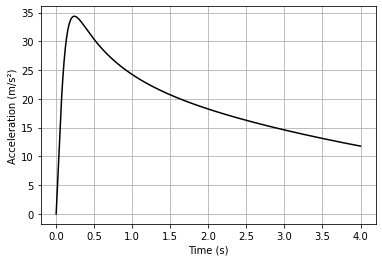

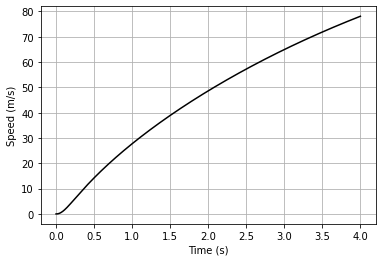

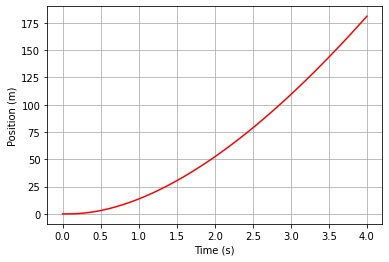

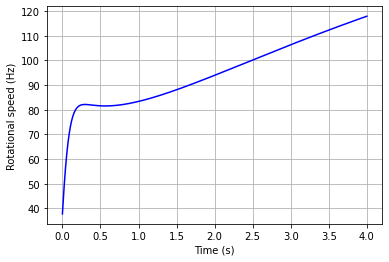

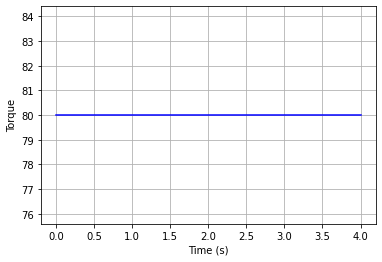

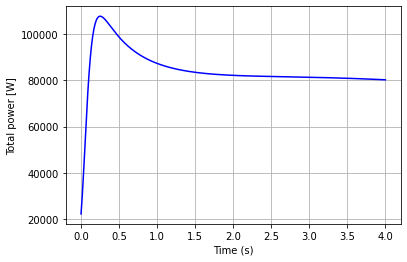

In [10]:
plot_trajectory(eval_problem.model.trajectory.trajectory.res)

The `variable-viewer` provides a way to inspect the content of the XML file. The dropdown lists above the table allow to filter the displayed variable.

In [11]:
api.variable_viewer(OUTPUT_FILE)

## 3. Running your first MDO

## CeRAS 2750 nm optimization

As seen earlier, the current aircraft configuration is estimated as unstable. We will fix this using a simple optimization problem that will move wing position so the static margin is at least +5%, while keeping the fuel consumption as low as possible. 

The default configuration file defines this optimization problem that aims at:
- minimizing the fuel consumption for the mission (objective),
- with respect to the wing position (design variables),
- subject to a static margin (constraints).

*(This run should take a few dozen seconds)*

To visualize and edit the optimization problem definition (present in the configuration file .toml) you can use the `optimization_viewer` tool. If design variables or constraints have active bounds they are yellow whereas they are red if they are violated. Modifiying the `Initial Value` will modify the input file defined in the configuration file .toml whereas `Value` corresponds to the value found in the output file defined in the configuration file (here it is the 800 nm MDA run).

In [12]:
api.optimization_viewer(CONFIGURATION_FILE)

In [28]:
optim_problem = api.optimize_problem(CONFIGURATION_FILE, overwrite=True)

Simulation interval    : 0.0 - 3.9999999999999996 seconds.
Elapsed simulation time: 0.01783309999973426 seconds.
Simulation interval    : 0.0 - 3.9999999999999996 seconds.
Elapsed simulation time: 0.018730699999650824 seconds.
Simulation interval    : 0.0 - 3.9999999999999996 seconds.
Elapsed simulation time: 0.019703599999957078 seconds.
Simulation interval    : 0.0 - 3.9999999999999996 seconds.
Elapsed simulation time: 0.01991390000057436 seconds.
Simulation interval    : 0.0 - 3.9999999999999996 seconds.
Elapsed simulation time: 0.018528600000536244 seconds.
Simulation interval    : 0.0 - 3.9999999999999996 seconds.
Elapsed simulation time: 0.018064899999444606 seconds.
Simulation interval    : 0.0 - 3.9999999999999996 seconds.
Elapsed simulation time: 0.018373500000052445 seconds.
Simulation interval    : 0.0 - 3.9999999999999996 seconds.
Elapsed simulation time: 0.017785299999559356 seconds.
Simulation interval    : 0.0 - 3.9999999999999996 seconds.
Elapsed simulation time: 0.0176

Simulation interval    : 0.0 - 4.232705537095284 seconds.
Elapsed simulation time: 0.01921050000055402 seconds.
Simulation interval    : 0.0 - 4.232705537095284 seconds.
Elapsed simulation time: 0.018013999999311636 seconds.
Simulation interval    : 0.0 - 4.232705537095284 seconds.
Elapsed simulation time: 0.018204299999524665 seconds.
Simulation interval    : 0.0 - 4.828832594119602 seconds.
Elapsed simulation time: 0.0186266999999134 seconds.
Simulation interval    : 0.0 - 4.828832594119602 seconds.
Elapsed simulation time: 0.018402400000013586 seconds.
Simulation interval    : 0.0 - 4.828832594119602 seconds.
Elapsed simulation time: 0.018695300000217685 seconds.
Simulation interval    : 0.0 - 4.828832594119602 seconds.
Elapsed simulation time: 0.018028500000582426 seconds.
Simulation interval    : 0.0 - 4.828832594119602 seconds.
Elapsed simulation time: 0.018613100000038685 seconds.
Simulation interval    : 0.0 - 4.828832594119602 seconds.
Elapsed simulation time: 0.01902979999977

Simulation interval    : 0.0 - 6.7665877012653315 seconds.
Elapsed simulation time: 0.018360199999733595 seconds.
Simulation interval    : 0.0 - 6.7665877012653315 seconds.
Elapsed simulation time: 0.01885299999958079 seconds.
Simulation interval    : 0.0 - 6.7665877012653315 seconds.
Elapsed simulation time: 0.018364200000178243 seconds.
Simulation interval    : 0.0 - 6.7665877012653315 seconds.
Elapsed simulation time: 0.01875689999997121 seconds.
Simulation interval    : 0.0 - 6.7665877012653315 seconds.
Elapsed simulation time: 0.018809199999850534 seconds.
Simulation interval    : 0.0 - 6.7665877012653315 seconds.
Elapsed simulation time: 0.018056300000353076 seconds.
Simulation interval    : 0.0 - 6.7665877012653315 seconds.
Elapsed simulation time: 0.018476600000212784 seconds.
Simulation interval    : 0.0 - 5.749517388724979 seconds.
Elapsed simulation time: 0.01841130000047997 seconds.
Simulation interval    : 0.0 - 5.749517388724979 seconds.
Elapsed simulation time: 0.0184464

Simulation interval    : 0.0 - 5.838975601982372 seconds.
Elapsed simulation time: 0.018535500000325555 seconds.
Simulation interval    : 0.0 - 5.838975601982372 seconds.
Elapsed simulation time: 0.01874130000032892 seconds.
Simulation interval    : 0.0 - 5.838975601982372 seconds.
Elapsed simulation time: 0.018560900000011316 seconds.
Simulation interval    : 0.0 - 5.838975601982372 seconds.
Elapsed simulation time: 0.017970200000490877 seconds.
Simulation interval    : 0.0 - 5.838975601982372 seconds.
Elapsed simulation time: 0.018277199999829463 seconds.
Simulation interval    : 0.0 - 5.838975601982372 seconds.
Elapsed simulation time: 0.01913929999955144 seconds.
Simulation interval    : 0.0 - 5.838975601982372 seconds.
Elapsed simulation time: 0.018810400000802474 seconds.
Simulation interval    : 0.0 - 5.838975601982372 seconds.
Elapsed simulation time: 0.018134899999495246 seconds.
Simulation interval    : 0.0 - 5.838975601982372 seconds.
Elapsed simulation time: 0.0181419999998

Simulation interval    : 0.0 - 4.7019992042668415 seconds.
Elapsed simulation time: 0.01879099999950995 seconds.
Simulation interval    : 0.0 - 4.701998204266841 seconds.
Elapsed simulation time: 0.018462799999724666 seconds.
Simulation interval    : 0.0 - 4.701998204266841 seconds.
Elapsed simulation time: 0.01861509999980626 seconds.
Simulation interval    : 0.0 - 4.701998204266841 seconds.
Elapsed simulation time: 0.018227000000479165 seconds.
Simulation interval    : 0.0 - 4.701998204266841 seconds.
Elapsed simulation time: 0.019191500000488304 seconds.
Simulation interval    : 0.0 - 4.701998204266841 seconds.
Elapsed simulation time: 0.020423099999788974 seconds.
Simulation interval    : 0.0 - 4.701998204266841 seconds.
Elapsed simulation time: 0.01890499999990425 seconds.
Simulation interval    : 0.0 - 4.701998204266841 seconds.
Elapsed simulation time: 0.01837500000056025 seconds.
Simulation interval    : 0.0 - 4.701998204266841 seconds.
Elapsed simulation time: 0.01824609999948

Simulation interval    : 0.0 - 2.3869162603445995 seconds.
Elapsed simulation time: 0.017950800000107847 seconds.
Simulation interval    : 0.0 - 2.3869162603445995 seconds.
Elapsed simulation time: 0.018328399999518297 seconds.
Simulation interval    : 0.0 - 2.3869162603445995 seconds.
Elapsed simulation time: 0.019696700000167766 seconds.
Simulation interval    : 0.0 - 2.3869172603445987 seconds.
Elapsed simulation time: 0.01881950000006327 seconds.
Simulation interval    : 0.0 - 2.3869162603445995 seconds.
Elapsed simulation time: 0.019335999999384512 seconds.
Simulation interval    : 0.0 - 2.3869162603445995 seconds.
Elapsed simulation time: 0.01927140000043437 seconds.
Simulation interval    : 0.0 - 2.3869162603445995 seconds.
Elapsed simulation time: 0.018297999999958847 seconds.
Simulation interval    : 0.0 - 2.3869162603445995 seconds.
Elapsed simulation time: 0.018147900000258232 seconds.
Simulation interval    : 0.0 - 2.3869162603445995 seconds.
Elapsed simulation time: 0.0180

Simulation interval    : 0.0 - 2.1837213598452845 seconds.
Elapsed simulation time: 0.018189200000051642 seconds.
Simulation interval    : 0.0 - 2.2808804709929698 seconds.
Elapsed simulation time: 0.01924319999943691 seconds.
Simulation interval    : 0.0 - 2.2040342136725806 seconds.
Elapsed simulation time: 0.019724099999621103 seconds.
Simulation interval    : 0.0 - 2.18872067950955 seconds.
Elapsed simulation time: 0.018781599999783793 seconds.
Simulation interval    : 0.0 - 2.1849741505326024 seconds.
Elapsed simulation time: 0.01937679999991815 seconds.
Simulation interval    : 0.0 - 2.184118138557291 seconds.
Elapsed simulation time: 0.019218999999793596 seconds.
Simulation interval    : 0.0 - 2.184118138557291 seconds.
Elapsed simulation time: 0.02011820000006992 seconds.
Simulation interval    : 0.0 - 2.184118138557291 seconds.
Elapsed simulation time: 0.018568499999673804 seconds.
Simulation interval    : 0.0 - 2.184118138557291 seconds.
Elapsed simulation time: 0.01856420000

Simulation interval    : 0.0 - 2.478162355978473 seconds.
Elapsed simulation time: 0.0190509000003658 seconds.
Simulation interval    : 0.0 - 2.478162355978473 seconds.
Elapsed simulation time: 0.018906500000412052 seconds.
Simulation interval    : 0.0 - 2.478162355978473 seconds.
Elapsed simulation time: 0.018037699999695178 seconds.
Simulation interval    : 0.0 - 2.478162355978473 seconds.
Elapsed simulation time: 0.018068399999719986 seconds.
Simulation interval    : 0.0 - 2.478162355978473 seconds.
Elapsed simulation time: 0.018698800000493065 seconds.
Simulation interval    : 0.0 - 2.478162355978473 seconds.
Elapsed simulation time: 0.027703700000529352 seconds.
Simulation interval    : 0.0 - 2.478162355978473 seconds.
Elapsed simulation time: 0.01879099999950995 seconds.
Simulation interval    : 0.0 - 2.478162355978473 seconds.
Elapsed simulation time: 0.019333000000187894 seconds.
Simulation interval    : 0.0 - 2.478162355978473 seconds.
Elapsed simulation time: 0.01827330000014

Simulation interval    : 0.0 - 2.8020457266461674 seconds.
Elapsed simulation time: 0.018842899999981455 seconds.
Simulation interval    : 0.0 - 2.8020457266461674 seconds.
Elapsed simulation time: 0.018252400000164926 seconds.
Simulation interval    : 0.0 - 2.8020457266461674 seconds.
Elapsed simulation time: 0.018076699999255652 seconds.
Simulation interval    : 0.0 - 2.8020457266461674 seconds.
Elapsed simulation time: 0.018351499999880616 seconds.
Simulation interval    : 0.0 - 2.802046726646167 seconds.
Elapsed simulation time: 0.019000100000084785 seconds.
Simulation interval    : 0.0 - 2.8020457266461674 seconds.
Elapsed simulation time: 0.018523300000197196 seconds.
Simulation interval    : 0.0 - 2.8020457266461674 seconds.
Elapsed simulation time: 0.01895310000054451 seconds.
Simulation interval    : 0.0 - 2.8020457266461674 seconds.
Elapsed simulation time: 0.018330799999603187 seconds.
Simulation interval    : 0.0 - 2.8020457266461674 seconds.
Elapsed simulation time: 0.0211

Simulation interval    : 0.0 - 2.7931983159549714 seconds.
Elapsed simulation time: 0.01902680000057444 seconds.
Simulation interval    : 0.0 - 2.7931983159549714 seconds.
Elapsed simulation time: 0.01830599999993865 seconds.
Simulation interval    : 0.0 - 2.7931983159549714 seconds.
Elapsed simulation time: 0.018686000000343483 seconds.
Simulation interval    : 0.0 - 2.7931983159549714 seconds.
Elapsed simulation time: 0.019348799999534094 seconds.
Simulation interval    : 0.0 - 2.975961794644134 seconds.
Elapsed simulation time: 0.02001970000037545 seconds.
Simulation interval    : 0.0 - 2.816380927479222 seconds.
Elapsed simulation time: 0.01842099999976199 seconds.
Simulation interval    : 0.0 - 2.816380927479222 seconds.
Elapsed simulation time: 0.01902410000002419 seconds.
Simulation interval    : 0.0 - 2.816380927479222 seconds.
Elapsed simulation time: 0.018791400000736758 seconds.
Simulation interval    : 0.0 - 2.816380927479222 seconds.
Elapsed simulation time: 0.018898899999

Simulation interval    : 0.0 - 2.8474231140770865 seconds.
Elapsed simulation time: 0.01820309999948222 seconds.
Simulation interval    : 0.0 - 2.8474231140770865 seconds.
Elapsed simulation time: 0.019077399999332556 seconds.
Simulation interval    : 0.0 - 2.8474231140770865 seconds.
Elapsed simulation time: 0.018121699999937846 seconds.
Simulation interval    : 0.0 - 2.8474231140770865 seconds.
Elapsed simulation time: 0.020897600000353123 seconds.
Simulation interval    : 0.0 - 2.8474231140770865 seconds.
Elapsed simulation time: 0.019384300000638177 seconds.
Simulation interval    : 0.0 - 2.8474231140770865 seconds.
Elapsed simulation time: 0.03247360000023036 seconds.
Simulation interval    : 0.0 - 2.8474231140770865 seconds.
Elapsed simulation time: 0.01862009999967995 seconds.
Simulation interval    : 0.0 - 2.8474231140770865 seconds.
Elapsed simulation time: 0.018234999999549473 seconds.
Simulation interval    : 0.0 - 2.8474231140770865 seconds.
Elapsed simulation time: 0.01899

Simulation interval    : 0.0 - 2.846617467780124 seconds.
Elapsed simulation time: 0.018755099999907543 seconds.
Simulation interval    : 0.0 - 2.846617467780124 seconds.
Elapsed simulation time: 0.018258000000059837 seconds.
Simulation interval    : 0.0 - 2.846617467780124 seconds.
Elapsed simulation time: 0.018007599999691593 seconds.
Simulation interval    : 0.0 - 2.846617467780124 seconds.
Elapsed simulation time: 0.01937439999983326 seconds.
Simulation interval    : 0.0 - 2.846617467780124 seconds.
Elapsed simulation time: 0.01890559999992547 seconds.
Simulation interval    : 0.0 - 2.846617467780124 seconds.
Elapsed simulation time: 0.01832360000025801 seconds.
Simulation interval    : 0.0 - 2.846617467780124 seconds.
Elapsed simulation time: 0.022340800000165473 seconds.
Simulation interval    : 0.0 - 2.8466184677801243 seconds.
Elapsed simulation time: 0.01971140000023297 seconds.
Simulation interval    : 0.0 - 2.846617467780124 seconds.
Elapsed simulation time: 0.01851230000011

Simulation interval    : 0.0 - 2.841967260912073 seconds.
Elapsed simulation time: 0.018852300000617106 seconds.
Simulation interval    : 0.0 - 2.841967260912073 seconds.
Elapsed simulation time: 0.018632199999956356 seconds.
Simulation interval    : 0.0 - 2.841967260912073 seconds.
Elapsed simulation time: 0.017862600000626117 seconds.
Simulation interval    : 0.0 - 2.841967260912073 seconds.
Elapsed simulation time: 0.01903480000055424 seconds.
Simulation interval    : 0.0 - 2.841967260912073 seconds.
Elapsed simulation time: 0.018464099999619066 seconds.
Simulation interval    : 0.0 - 2.841967260912073 seconds.
Elapsed simulation time: 0.018168300000070303 seconds.
Simulation interval    : 0.0 - 2.841967260912073 seconds.
Elapsed simulation time: 0.018652799999472336 seconds.
Simulation interval    : 0.0 - 2.841967260912073 seconds.
Elapsed simulation time: 0.018646499999704247 seconds.
Simulation interval    : 0.0 - 2.841967260912073 seconds.
Elapsed simulation time: 0.018184199999

Simulation interval    : 0.0 - 2.929087513320365 seconds.
Elapsed simulation time: 0.021867500000553264 seconds.
Simulation interval    : 0.0 - 2.929069088170165 seconds.
Elapsed simulation time: 0.019362400000318303 seconds.
Simulation interval    : 0.0 - 2.929069088170165 seconds.
Elapsed simulation time: 0.02629160000014963 seconds.
Simulation interval    : 0.0 - 2.929069088170165 seconds.
Elapsed simulation time: 0.01870729999973264 seconds.
Simulation interval    : 0.0 - 2.929069088170165 seconds.
Elapsed simulation time: 0.018892500000220025 seconds.
Simulation interval    : 0.0 - 2.929069088170165 seconds.
Elapsed simulation time: 0.017830800000410818 seconds.
Simulation interval    : 0.0 - 2.929069088170165 seconds.
Elapsed simulation time: 0.019642100000055507 seconds.
Simulation interval    : 0.0 - 2.929069088170165 seconds.
Elapsed simulation time: 0.019543800000064948 seconds.
Simulation interval    : 0.0 - 2.929069088170165 seconds.
Elapsed simulation time: 0.0185454000002

Simulation interval    : 0.0 - 2.9347435499542653 seconds.
Elapsed simulation time: 0.018646399999852292 seconds.
Simulation interval    : 0.0 - 2.9347435499542653 seconds.
Elapsed simulation time: 0.018693600000005972 seconds.
Simulation interval    : 0.0 - 2.9347435499542653 seconds.
Elapsed simulation time: 0.018194999999650463 seconds.
Simulation interval    : 0.0 - 2.9347435499542653 seconds.
Elapsed simulation time: 0.018548699999882956 seconds.
Simulation interval    : 0.0 - 2.9347435499542653 seconds.
Elapsed simulation time: 0.018492600000172388 seconds.
Simulation interval    : 0.0 - 2.9347435499542653 seconds.
Elapsed simulation time: 0.017914800000653486 seconds.
Simulation interval    : 0.0 - 2.9347435499542653 seconds.
Elapsed simulation time: 0.018836999999621185 seconds.
Simulation interval    : 0.0 - 2.9347435499542653 seconds.
Elapsed simulation time: 0.019489500000418047 seconds.
Simulation interval    : 0.0 - 2.9347435499542653 seconds.
Elapsed simulation time: 0.01

Simulation interval    : 0.0 - 2.940326977061547 seconds.
Elapsed simulation time: 0.018197900000814116 seconds.
Simulation interval    : 0.0 - 2.940326977061547 seconds.
Elapsed simulation time: 0.01918660000046657 seconds.
Simulation interval    : 0.0 - 2.940326977061547 seconds.
Elapsed simulation time: 0.01822840000022552 seconds.
Simulation interval    : 0.0 - 2.940326977061547 seconds.
Elapsed simulation time: 0.01800970000022062 seconds.
Simulation interval    : 0.0 - 2.940326977061547 seconds.
Elapsed simulation time: 0.019215299999814306 seconds.
Simulation interval    : 0.0 - 2.940326977061547 seconds.
Elapsed simulation time: 0.018369999999777065 seconds.
Simulation interval    : 0.0 - 2.940326977061547 seconds.
Elapsed simulation time: 0.019265599999926053 seconds.
Simulation interval    : 0.0 - 2.9403279770615476 seconds.
Elapsed simulation time: 0.018888800000240735 seconds.
Simulation interval    : 0.0 - 2.940326977061547 seconds.
Elapsed simulation time: 0.0191531000000

Simulation interval    : 0.0 - 2.9920083043890546 seconds.
Elapsed simulation time: 0.018614999999954307 seconds.
Simulation interval    : 0.0 - 2.9920083043890546 seconds.
Elapsed simulation time: 0.01854079999975511 seconds.
Simulation interval    : 0.0 - 2.9920083043890546 seconds.
Elapsed simulation time: 0.019417800000155694 seconds.
Simulation interval    : 0.0 - 2.9920083043890546 seconds.
Elapsed simulation time: 0.018254300000080548 seconds.
Simulation interval    : 0.0 - 2.9920083043890546 seconds.
Elapsed simulation time: 0.01826210000035644 seconds.
Simulation interval    : 0.0 - 2.9920083043890546 seconds.
Elapsed simulation time: 0.019407000000683183 seconds.
Simulation interval    : 0.0 - 2.9920083043890546 seconds.
Elapsed simulation time: 0.01809140000023035 seconds.
Simulation interval    : 0.0 - 3.226673628771109 seconds.
Elapsed simulation time: 0.018460500000401225 seconds.
Simulation interval    : 0.0 - 3.01547483682726 seconds.
Elapsed simulation time: 0.01852830

Elapsed simulation time: 0.018396100000245497 seconds.
Simulation interval    : 0.0 - 2.999246831584902 seconds.
Elapsed simulation time: 0.01868339999964519 seconds.
Simulation interval    : 0.0 - 2.9992478315849014 seconds.
Elapsed simulation time: 0.018480199999430624 seconds.
Simulation interval    : 0.0 - 2.999246831584902 seconds.
Elapsed simulation time: 0.019017499999790743 seconds.
Simulation interval    : 0.0 - 2.999246831584902 seconds.
Elapsed simulation time: 0.017985399999815854 seconds.
Simulation interval    : 0.0 - 2.999246831584902 seconds.
Elapsed simulation time: 0.018114600000444625 seconds.
Simulation interval    : 0.0 - 2.999246831584902 seconds.
Elapsed simulation time: 0.01928169999973761 seconds.
Simulation interval    : 0.0 - 2.999246831584902 seconds.
Elapsed simulation time: 0.019666500000312226 seconds.
Simulation interval    : 0.0 - 2.999246831584902 seconds.
Elapsed simulation time: 0.01883460000044579 seconds.
Simulation interval    : 0.0 - 2.9992468315

Simulation interval    : 0.0 - 2.99954883191289 seconds.
Elapsed simulation time: 0.01914039999974193 seconds.
Simulation interval    : 0.0 - 2.99954883191289 seconds.
Elapsed simulation time: 0.018685000000004948 seconds.
Simulation interval    : 0.0 - 2.99954883191289 seconds.
Elapsed simulation time: 0.018207999999503954 seconds.
Simulation interval    : 0.0 - 3.0650200207932805 seconds.
Elapsed simulation time: 0.01867939999920054 seconds.
Simulation interval    : 0.0 - 3.006095950800929 seconds.
Elapsed simulation time: 0.018332800000280258 seconds.
Simulation interval    : 0.0 - 3.000203543801693 seconds.
Elapsed simulation time: 0.018938000000161992 seconds.
Simulation interval    : 0.0 - 2.9996143031017697 seconds.
Elapsed simulation time: 0.01839190000009694 seconds.
Simulation interval    : 0.0 - 2.9996143031017697 seconds.
Elapsed simulation time: 0.019291900000098394 seconds.
Simulation interval    : 0.0 - 2.9996143031017697 seconds.
Elapsed simulation time: 0.0184340000005

Simulation interval    : 0.0 - 2.9996206670517864 seconds.
Elapsed simulation time: 0.019390399999792862 seconds.
Simulation interval    : 0.0 - 2.9996206670517864 seconds.
Elapsed simulation time: 0.021441900000354508 seconds.
Simulation interval    : 0.0 - 2.999621667051787 seconds.
Elapsed simulation time: 0.018720500000199536 seconds.
Simulation interval    : 0.0 - 2.9996206670517864 seconds.
Elapsed simulation time: 0.01902709999922081 seconds.
Simulation interval    : 0.0 - 2.9996206670517864 seconds.
Elapsed simulation time: 0.017915999999786436 seconds.
Simulation interval    : 0.0 - 2.9996206670517864 seconds.
Elapsed simulation time: 0.018058200000268698 seconds.
Simulation interval    : 0.0 - 2.9996206670517864 seconds.
Elapsed simulation time: 0.018539799999416573 seconds.
Simulation interval    : 0.0 - 2.9996206670517864 seconds.
Elapsed simulation time: 0.019682600000123784 seconds.
Simulation interval    : 0.0 - 2.9996206670517864 seconds.
Elapsed simulation time: 0.0182

Simulation interval    : 0.0 - 2.999606865949786 seconds.
Elapsed simulation time: 0.01869200000055571 seconds.
Simulation interval    : 0.0 - 2.999606865949786 seconds.
Elapsed simulation time: 0.018829000000550877 seconds.
Simulation interval    : 0.0 - 2.999606865949786 seconds.
Elapsed simulation time: 0.01857930000005581 seconds.
Simulation interval    : 0.0 - 2.999606865949786 seconds.
Elapsed simulation time: 0.019173700000465033 seconds.
Simulation interval    : 0.0 - 2.899964921814114 seconds.
Elapsed simulation time: 0.019939800000429386 seconds.
Simulation interval    : 0.0 - 2.989642671536219 seconds.
Elapsed simulation time: 0.018395199999758916 seconds.
Simulation interval    : 0.0 - 2.9986104465084296 seconds.
Elapsed simulation time: 0.01846930000010616 seconds.
Simulation interval    : 0.0 - 2.9995072240056504 seconds.
Elapsed simulation time: 0.019308599999931175 seconds.
Simulation interval    : 0.0 - 2.999596833482296 seconds.
Elapsed simulation time: 0.018302100000

Simulation interval    : 0.0 - 2.999604862015488 seconds.
Elapsed simulation time: 0.01953620000040246 seconds.
Simulation interval    : 0.0 - 2.999604862015488 seconds.
Elapsed simulation time: 0.02017840000007709 seconds.
Simulation interval    : 0.0 - 2.999604862015488 seconds.
Elapsed simulation time: 0.019804600000497885 seconds.
Simulation interval    : 0.0 - 2.999604862015488 seconds.
Elapsed simulation time: 0.019180200000846526 seconds.
Simulation interval    : 0.0 - 2.999604862015488 seconds.
Elapsed simulation time: 0.019111000000521017 seconds.
Simulation interval    : 0.0 - 2.999604862015488 seconds.
Elapsed simulation time: 0.018203500000709028 seconds.
Simulation interval    : 0.0 - 2.999604862015488 seconds.
Elapsed simulation time: 0.021179100000153994 seconds.
Simulation interval    : 0.0 - 2.999604862015488 seconds.
Elapsed simulation time: 0.018862699999772303 seconds.
Simulation interval    : 0.0 - 2.999604862015488 seconds.
Elapsed simulation time: 0.0183898999994

Simulation interval    : 0.0 - 2.842916937353449 seconds.
Elapsed simulation time: 0.034593999999742664 seconds.
Simulation interval    : 0.0 - 2.842916937353449 seconds.
Elapsed simulation time: 0.0185328000006848 seconds.
Simulation interval    : 0.0 - 2.842916937353449 seconds.
Elapsed simulation time: 0.018583599999146827 seconds.
Simulation interval    : 0.0 - 2.842916937353449 seconds.
Elapsed simulation time: 0.01867339999989781 seconds.
Simulation interval    : 0.0 - 2.842916937353449 seconds.
Elapsed simulation time: 0.01937610000004497 seconds.
Simulation interval    : 0.0 - 2.842916937353449 seconds.
Elapsed simulation time: 0.018202999999630265 seconds.
Simulation interval    : 0.0 - 3.1145495701574513 seconds.
Elapsed simulation time: 0.01846560000012687 seconds.
Simulation interval    : 0.0 - 2.9406202081890713 seconds.
Elapsed simulation time: 0.018271099999765283 seconds.
Simulation interval    : 0.0 - 2.8849780584625315 seconds.
Elapsed simulation time: 0.0195800000001

Simulation interval    : 0.0 - 2.906285086518403 seconds.
Elapsed simulation time: 0.02044220000061614 seconds.
Simulation interval    : 0.0 - 2.9062840865184025 seconds.
Elapsed simulation time: 0.01998139999977866 seconds.
Simulation interval    : 0.0 - 2.9062840865184025 seconds.
Elapsed simulation time: 0.019458700000541285 seconds.
Simulation interval    : 0.0 - 2.9062840865184025 seconds.
Elapsed simulation time: 0.018685699999878125 seconds.
Simulation interval    : 0.0 - 2.9062840865184025 seconds.
Elapsed simulation time: 0.018119200000001 seconds.
Simulation interval    : 0.0 - 2.9062840865184025 seconds.
Elapsed simulation time: 0.018141100000320876 seconds.
Simulation interval    : 0.0 - 2.9062840865184025 seconds.
Elapsed simulation time: 0.018165599999520055 seconds.
Simulation interval    : 0.0 - 2.9062840865184025 seconds.
Elapsed simulation time: 0.018398100000013073 seconds.
Simulation interval    : 0.0 - 2.9062840865184025 seconds.
Elapsed simulation time: 0.01856260

Simulation interval    : 0.0 - 3.0347247684701744 seconds.
Elapsed simulation time: 0.01968600000054721 seconds.
Simulation interval    : 0.0 - 2.922195231874375 seconds.
Elapsed simulation time: 0.01857949999975972 seconds.
Simulation interval    : 0.0 - 2.9109422782147947 seconds.
Elapsed simulation time: 0.01889489999939542 seconds.
Simulation interval    : 0.0 - 2.9109422782147947 seconds.
Elapsed simulation time: 0.018667899999854853 seconds.
Simulation interval    : 0.0 - 2.9109422782147947 seconds.
Elapsed simulation time: 0.03278729999965435 seconds.
Simulation interval    : 0.0 - 2.9109422782147947 seconds.
Elapsed simulation time: 0.01989309999953548 seconds.
Simulation interval    : 0.0 - 2.9109422782147947 seconds.
Elapsed simulation time: 0.018661700000848214 seconds.
Simulation interval    : 0.0 - 2.9109422782147947 seconds.
Elapsed simulation time: 0.01833840000017517 seconds.
Simulation interval    : 0.0 - 2.9109422782147947 seconds.
Elapsed simulation time: 0.018280999

Simulation interval    : 0.0 - 2.9142788570604368 seconds.
Elapsed simulation time: 0.018651200000022072 seconds.
Simulation interval    : 0.0 - 2.9142788570604368 seconds.
Elapsed simulation time: 0.018667199999981676 seconds.
Simulation interval    : 0.0 - 2.9142788570604368 seconds.
Elapsed simulation time: 0.021561100000326405 seconds.
Simulation interval    : 0.0 - 2.9142788570604368 seconds.
Elapsed simulation time: 0.030824200000097335 seconds.
Simulation interval    : 0.0 - 2.9142788570604368 seconds.
Elapsed simulation time: 0.018652900000233785 seconds.
Simulation interval    : 0.0 - 2.9142788570604368 seconds.
Elapsed simulation time: 0.020344399999885354 seconds.
Simulation interval    : 0.0 - 2.9142788570604368 seconds.
Elapsed simulation time: 0.02135089999956108 seconds.
Simulation interval    : 0.0 - 2.9142788570604368 seconds.
Elapsed simulation time: 0.018526599999859172 seconds.
Simulation interval    : 0.0 - 2.9142788570604368 seconds.
Elapsed simulation time: 0.018

Simulation interval    : 0.0 - 2.914926289600801 seconds.
Elapsed simulation time: 0.020759799999723327 seconds.
Simulation interval    : 0.0 - 2.914926289600801 seconds.
Elapsed simulation time: 0.020077199999832374 seconds.
Simulation interval    : 0.0 - 2.914926289600801 seconds.
Elapsed simulation time: 0.01831419999962236 seconds.
Simulation interval    : 0.0 - 2.914926289600801 seconds.
Elapsed simulation time: 0.018268699999680393 seconds.
Simulation interval    : 0.0 - 2.914926289600801 seconds.
Elapsed simulation time: 0.018439299999954528 seconds.
Simulation interval    : 0.0 - 2.914926289600801 seconds.
Elapsed simulation time: 0.01873760000034963 seconds.
Simulation interval    : 0.0 - 2.914926289600801 seconds.
Elapsed simulation time: 0.01952889999938634 seconds.
Simulation interval    : 0.0 - 2.914926289600801 seconds.
Elapsed simulation time: 0.018080199999531033 seconds.
Simulation interval    : 0.0 - 2.914926289600801 seconds.
Elapsed simulation time: 0.02072709999993

Simulation interval    : 0.0 - 2.9149595649671474 seconds.
Elapsed simulation time: 0.02193749999969441 seconds.
Simulation interval    : 0.0 - 2.9149595649671474 seconds.
Elapsed simulation time: 0.018191599999227037 seconds.
Simulation interval    : 0.0 - 2.9149595649671474 seconds.
Elapsed simulation time: 0.01855539999996836 seconds.
Simulation interval    : 0.0 - 2.9149595649671474 seconds.
Elapsed simulation time: 0.0375597000002017 seconds.
Simulation interval    : 0.0 - 2.9149595649671474 seconds.
Elapsed simulation time: 0.018823000000338652 seconds.
Simulation interval    : 0.0 - 2.9149595649671474 seconds.
Elapsed simulation time: 0.01866879999943194 seconds.
Simulation interval    : 0.0 - 2.9149595649671474 seconds.
Elapsed simulation time: 0.018347600000197417 seconds.
Simulation interval    : 0.0 - 2.9149595649671474 seconds.
Elapsed simulation time: 0.018340700000408106 seconds.
Simulation interval    : 0.0 - 2.9149595649671474 seconds.
Elapsed simulation time: 0.0181911

Simulation interval    : 0.0 - 3.0865526994343315 seconds.
Elapsed simulation time: 0.0209088999999949 seconds.
Simulation interval    : 0.0 - 2.9321211489486054 seconds.
Elapsed simulation time: 0.018668699999579985 seconds.
Simulation interval    : 0.0 - 2.9166779939000333 seconds.
Elapsed simulation time: 0.018672300000616815 seconds.
Simulation interval    : 0.0 - 2.9151336783951756 seconds.
Elapsed simulation time: 0.01898299999993469 seconds.
Simulation interval    : 0.0 - 2.9149792468446902 seconds.
Elapsed simulation time: 0.018265900000187685 seconds.
Simulation interval    : 0.0 - 2.9149638036896413 seconds.
Elapsed simulation time: 0.018716499999754888 seconds.
Simulation interval    : 0.0 - 2.9149623328496426 seconds.
Elapsed simulation time: 0.01841690000037488 seconds.
Simulation interval    : 0.0 - 2.9149623328496426 seconds.
Elapsed simulation time: 0.01907240000036836 seconds.
Simulation interval    : 0.0 - 2.9149623328496426 seconds.
Elapsed simulation time: 0.0188072

Simulation interval    : 0.0 - 2.9149628759736017 seconds.
Elapsed simulation time: 0.020203399999445537 seconds.
Simulation interval    : 0.0 - 2.9149628759736017 seconds.
Elapsed simulation time: 0.020518400000582915 seconds.
Simulation interval    : 0.0 - 2.9149628759736017 seconds.
Elapsed simulation time: 0.01815009999972972 seconds.
Simulation interval    : 0.0 - 2.9149628759736017 seconds.
Elapsed simulation time: 0.018683100000089325 seconds.
Simulation interval    : 0.0 - 2.9149628759736017 seconds.
Elapsed simulation time: 0.01829150000048685 seconds.
Simulation interval    : 0.0 - 2.9149628759736017 seconds.
Elapsed simulation time: 0.018929599999864877 seconds.
Simulation interval    : 0.0 - 2.9149628759736017 seconds.
Elapsed simulation time: 0.019109900000330526 seconds.
Simulation interval    : 0.0 - 2.914963875973602 seconds.
Elapsed simulation time: 0.018931200000224635 seconds.
Simulation interval    : 0.0 - 2.9149628759736017 seconds.
Elapsed simulation time: 0.01833

Simulation interval    : 0.0 - 2.9149639219375656 seconds.
Elapsed simulation time: 0.019077300000390096 seconds.
Simulation interval    : 0.0 - 2.9149629219375655 seconds.
Elapsed simulation time: 0.01891390000037063 seconds.
Simulation interval    : 0.0 - 2.9149629219375655 seconds.
Elapsed simulation time: 0.018876900000577734 seconds.
Simulation interval    : 0.0 - 2.9149629219375655 seconds.
Elapsed simulation time: 0.018672199999855366 seconds.
Simulation interval    : 0.0 - 2.9149629219375655 seconds.
Elapsed simulation time: 0.019071900000199093 seconds.
Simulation interval    : 0.0 - 2.9149629219375655 seconds.
Elapsed simulation time: 0.019057599999541708 seconds.
Simulation interval    : 0.0 - 2.9149629219375655 seconds.
Elapsed simulation time: 0.018793100000038976 seconds.
Simulation interval    : 0.0 - 2.9149629219375655 seconds.
Elapsed simulation time: 0.01893629999995028 seconds.
Simulation interval    : 0.0 - 2.9149629219375655 seconds.
Elapsed simulation time: 0.0187

Simulation interval    : 0.0 - 2.9149629575572713 seconds.
Elapsed simulation time: 0.018466200000148092 seconds.
Simulation interval    : 0.0 - 2.9149629575572713 seconds.
Elapsed simulation time: 0.01942609999969136 seconds.
Simulation interval    : 0.0 - 2.9149629575572713 seconds.
Elapsed simulation time: 0.01918680000017048 seconds.
Simulation interval    : 0.0 - 2.9149629575572713 seconds.
Elapsed simulation time: 0.01914929999929882 seconds.
Simulation interval    : 0.0 - 2.9149629575572713 seconds.
Elapsed simulation time: 0.01852390000021842 seconds.
Simulation interval    : 0.0 - 2.9149629575572713 seconds.
Elapsed simulation time: 0.047060400000191294 seconds.
Simulation interval    : 0.0 - 2.9149629575572713 seconds.
Elapsed simulation time: 0.01835690000007162 seconds.
Simulation interval    : 0.0 - 2.9149629575572713 seconds.
Elapsed simulation time: 0.021372799999880954 seconds.
Simulation interval    : 0.0 - 2.9149629575572713 seconds.
Elapsed simulation time: 0.0210575

Simulation interval    : 0.0 - 2.914962644506501 seconds.
Elapsed simulation time: 0.02294900000015332 seconds.
Simulation interval    : 0.0 - 2.914962644506501 seconds.
Elapsed simulation time: 0.020996399999603454 seconds.
Simulation interval    : 0.0 - 2.914962644506501 seconds.
Elapsed simulation time: 0.02011060000040743 seconds.
Simulation interval    : 0.0 - 2.914962644506501 seconds.
Elapsed simulation time: 0.018837399999938498 seconds.
Simulation interval    : 0.0 - 2.914962644506501 seconds.
Elapsed simulation time: 0.0184265999996569 seconds.
Simulation interval    : 0.0 - 2.914962644506501 seconds.
Elapsed simulation time: 0.018931399999928544 seconds.
Simulation interval    : 0.0 - 2.914962644506501 seconds.
Elapsed simulation time: 0.019511200000124518 seconds.
Simulation interval    : 0.0 - 2.914962644506501 seconds.
Elapsed simulation time: 0.01859340000009979 seconds.
Simulation interval    : 0.0 - 3.1160060687918443 seconds.
Elapsed simulation time: 0.018664899999748

Simulation interval    : 0.0 - 2.9149631591750587 seconds.
Elapsed simulation time: 0.019909699999516306 seconds.
Simulation interval    : 0.0 - 2.9149631591750587 seconds.
Elapsed simulation time: 0.019026999999368854 seconds.
Simulation interval    : 0.0 - 2.9149631591750587 seconds.
Elapsed simulation time: 0.018115599999873666 seconds.
Simulation interval    : 0.0 - 3.0543758912852916 seconds.
Elapsed simulation time: 0.0189327999996749 seconds.
Simulation interval    : 0.0 - 2.9446633073240407 seconds.
Elapsed simulation time: 0.01861509999980626 seconds.
Simulation interval    : 0.0 - 2.922944032643194 seconds.
Elapsed simulation time: 0.019470100000035018 seconds.
Simulation interval    : 0.0 - 2.9172072845995807 seconds.
Elapsed simulation time: 0.019315399999868532 seconds.
Simulation interval    : 0.0 - 2.9155970169061867 seconds.
Elapsed simulation time: 0.018734399999630114 seconds.
Simulation interval    : 0.0 - 2.915142432408528 seconds.
Elapsed simulation time: 0.0344236

Simulation interval    : 0.0 - 2.9116964298844805 seconds.
Elapsed simulation time: 0.020867399999588088 seconds.
Simulation interval    : 0.0 - 2.9116964298844805 seconds.
Elapsed simulation time: 0.018469599999662023 seconds.
Simulation interval    : 0.0 - 2.9116964298844805 seconds.
Elapsed simulation time: 0.0195346000000427 seconds.
Simulation interval    : 0.0 - 2.911697429884481 seconds.
Elapsed simulation time: 0.018938999999591033 seconds.
Simulation interval    : 0.0 - 2.9116964298844805 seconds.
Elapsed simulation time: 0.018739500000265252 seconds.
Simulation interval    : 0.0 - 2.9116964298844805 seconds.
Elapsed simulation time: 0.018976800000018557 seconds.
Simulation interval    : 0.0 - 2.9116964298844805 seconds.
Elapsed simulation time: 0.018048800000542542 seconds.
Simulation interval    : 0.0 - 2.9116964298844805 seconds.
Elapsed simulation time: 0.01855959999920742 seconds.
Simulation interval    : 0.0 - 2.9116964298844805 seconds.
Elapsed simulation time: 0.018355

Simulation interval    : 0.0 - 3.324443955010623 seconds.
Elapsed simulation time: 0.02147049999985029 seconds.
Simulation interval    : 0.0 - 3.0242096861103307 seconds.
Elapsed simulation time: 0.01932219999980589 seconds.
Simulation interval    : 0.0 - 2.9941862592203012 seconds.
Elapsed simulation time: 0.018689399999857415 seconds.
Simulation interval    : 0.0 - 2.9941862592203012 seconds.
Elapsed simulation time: 0.021075699999528297 seconds.
Simulation interval    : 0.0 - 2.9941862592203012 seconds.
Elapsed simulation time: 0.01845110000067507 seconds.
Simulation interval    : 0.0 - 2.9941862592203012 seconds.
Elapsed simulation time: 0.019337300000188407 seconds.
Simulation interval    : 0.0 - 2.9941862592203012 seconds.
Elapsed simulation time: 0.018195000000559958 seconds.
Simulation interval    : 0.0 - 2.9941862592203012 seconds.
Elapsed simulation time: 0.017920500000400352 seconds.
Simulation interval    : 0.0 - 2.9941862592203012 seconds.
Elapsed simulation time: 0.019029

Simulation interval    : 0.0 - 2.996066658089281 seconds.
Elapsed simulation time: 0.018850600000405393 seconds.
Simulation interval    : 0.0 - 2.996066658089281 seconds.
Elapsed simulation time: 0.018727700000454206 seconds.
Simulation interval    : 0.0 - 2.996066658089281 seconds.
Elapsed simulation time: 0.01854780000030587 seconds.
Simulation interval    : 0.0 - 2.996066658089281 seconds.
Elapsed simulation time: 0.019119500000670087 seconds.
Simulation interval    : 0.0 - 2.996066658089281 seconds.
Elapsed simulation time: 0.018133100000341074 seconds.
Simulation interval    : 0.0 - 2.996066658089281 seconds.
Elapsed simulation time: 0.017967800000405987 seconds.
Simulation interval    : 0.0 - 2.996066658089281 seconds.
Elapsed simulation time: 0.018637999999555177 seconds.
Simulation interval    : 0.0 - 2.996066658089281 seconds.
Elapsed simulation time: 0.019073499999649357 seconds.
Simulation interval    : 0.0 - 2.996066658089281 seconds.
Elapsed simulation time: 0.018361299999

Simulation interval    : 0.0 - 2.9967570556609053 seconds.
Elapsed simulation time: 0.018254800000249816 seconds.
Simulation interval    : 0.0 - 2.9967570556609053 seconds.
Elapsed simulation time: 0.02132080000046699 seconds.
Simulation interval    : 0.0 - 2.9967570556609053 seconds.
Elapsed simulation time: 0.018089799999870593 seconds.
Simulation interval    : 0.0 - 2.9967570556609053 seconds.
Elapsed simulation time: 0.018815899999935937 seconds.
Simulation interval    : 0.0 - 2.9967570556609053 seconds.
Elapsed simulation time: 0.028645999999753258 seconds.
Simulation interval    : 0.0 - 2.9967570556609053 seconds.
Elapsed simulation time: 0.018706400000155554 seconds.
Simulation interval    : 0.0 - 2.9967570556609053 seconds.
Elapsed simulation time: 0.018427399999382033 seconds.
Simulation interval    : 0.0 - 2.9967570556609053 seconds.
Elapsed simulation time: 0.01883579999957874 seconds.
Simulation interval    : 0.0 - 2.9967570556609053 seconds.
Elapsed simulation time: 0.0189

Simulation interval    : 0.0 - 2.9973340065688006 seconds.
Elapsed simulation time: 0.018292400000063935 seconds.
Simulation interval    : 0.0 - 2.9973340065688006 seconds.
Elapsed simulation time: 0.018275300000823336 seconds.
Simulation interval    : 0.0 - 2.9973340065688006 seconds.
Elapsed simulation time: 0.0190242999997281 seconds.
Simulation interval    : 0.0 - 2.9973340065688006 seconds.
Elapsed simulation time: 0.04310979999991105 seconds.
Simulation interval    : 0.0 - 2.9973340065688006 seconds.
Elapsed simulation time: 0.025448600000345323 seconds.
Simulation interval    : 0.0 - 2.9973340065688006 seconds.
Elapsed simulation time: 0.018620800000462623 seconds.
Simulation interval    : 0.0 - 2.9973340065688006 seconds.
Elapsed simulation time: 0.01876700000048004 seconds.
Simulation interval    : 0.0 - 2.9973340065688006 seconds.
Elapsed simulation time: 0.01810970000042289 seconds.
Simulation interval    : 0.0 - 2.9973340065688006 seconds.
Elapsed simulation time: 0.0189276

Simulation interval    : 0.0 - 3.0031038284329408 seconds.
Elapsed simulation time: 0.018969100000504113 seconds.
Simulation interval    : 0.0 - 2.998318839827878 seconds.
Elapsed simulation time: 0.020620899999812536 seconds.
Simulation interval    : 0.0 - 2.9975949917085916 seconds.
Elapsed simulation time: 0.01864890000069863 seconds.
Simulation interval    : 0.0 - 2.997486008462566 seconds.
Elapsed simulation time: 0.01954299999943032 seconds.
Simulation interval    : 0.0 - 2.997486008462566 seconds.
Elapsed simulation time: 0.018827900000360387 seconds.
Simulation interval    : 0.0 - 2.997486008462566 seconds.
Elapsed simulation time: 0.018874899999900663 seconds.
Simulation interval    : 0.0 - 2.997486008462566 seconds.
Elapsed simulation time: 0.018274600000040664 seconds.
Simulation interval    : 0.0 - 2.997486008462566 seconds.
Elapsed simulation time: 0.018428499999572523 seconds.
Simulation interval    : 0.0 - 2.997486008462566 seconds.
Elapsed simulation time: 0.01846179999

Simulation interval    : 0.0 - 2.997486823151881 seconds.
Elapsed simulation time: 0.02123050000045623 seconds.
Simulation interval    : 0.0 - 2.9974863076031864 seconds.
Elapsed simulation time: 0.019402699999773176 seconds.
Simulation interval    : 0.0 - 2.9974861958803998 seconds.
Elapsed simulation time: 0.020249299999704817 seconds.
Simulation interval    : 0.0 - 2.9974861958803998 seconds.
Elapsed simulation time: 0.018372800000179268 seconds.
Simulation interval    : 0.0 - 2.9974861958803998 seconds.
Elapsed simulation time: 0.019483000000036554 seconds.
Simulation interval    : 0.0 - 2.9974861958803998 seconds.
Elapsed simulation time: 0.018146699999306293 seconds.
Simulation interval    : 0.0 - 2.9974861958803998 seconds.
Elapsed simulation time: 0.019414600000345672 seconds.
Simulation interval    : 0.0 - 2.9974861958803998 seconds.
Elapsed simulation time: 0.01899539999976696 seconds.
Simulation interval    : 0.0 - 2.9974861958803998 seconds.
Elapsed simulation time: 0.01918

Simulation interval    : 0.0 - 2.968566534475117 seconds.
Elapsed simulation time: 0.01838450000013836 seconds.
Simulation interval    : 0.0 - 2.968566534475117 seconds.
Elapsed simulation time: 0.018622200000208977 seconds.
Simulation interval    : 0.0 - 2.968566534475117 seconds.
Elapsed simulation time: 0.01841100000001461 seconds.
Simulation interval    : 0.0 - 2.968566534475117 seconds.
Elapsed simulation time: 0.019507099999827915 seconds.
Simulation interval    : 0.0 - 2.968566534475117 seconds.
Elapsed simulation time: 0.01885130000027857 seconds.
Simulation interval    : 0.0 - 2.968566534475117 seconds.
Elapsed simulation time: 0.018422500000269793 seconds.
Simulation interval    : 0.0 - 2.968566534475117 seconds.
Elapsed simulation time: 0.02070099999946251 seconds.
Simulation interval    : 0.0 - 2.968566534475117 seconds.
Elapsed simulation time: 0.019095800000286545 seconds.
Simulation interval    : 0.0 - 2.968566534475117 seconds.
Elapsed simulation time: 0.018140999999559

Simulation interval    : 0.0 - 2.9724751093271653 seconds.
Elapsed simulation time: 0.021049500000117405 seconds.
Simulation interval    : 0.0 - 2.9724751093271653 seconds.
Elapsed simulation time: 0.018229600000267965 seconds.
Simulation interval    : 0.0 - 2.9724751093271653 seconds.
Elapsed simulation time: 0.018720000000030268 seconds.
Simulation interval    : 0.0 - 2.9724751093271653 seconds.
Elapsed simulation time: 0.018825500000275497 seconds.
Simulation interval    : 0.0 - 2.972476109327166 seconds.
Elapsed simulation time: 0.027277700000013283 seconds.
Simulation interval    : 0.0 - 2.9724751093271653 seconds.
Elapsed simulation time: 0.019344100000125763 seconds.
Simulation interval    : 0.0 - 2.9724751093271653 seconds.
Elapsed simulation time: 0.01809010000033595 seconds.
Simulation interval    : 0.0 - 2.9724751093271653 seconds.
Elapsed simulation time: 0.01819230000000971 seconds.
Simulation interval    : 0.0 - 2.9724751093271653 seconds.
Elapsed simulation time: 0.01862

Simulation interval    : 0.0 - 2.9730956687869092 seconds.
Elapsed simulation time: 0.018105699999978242 seconds.
Simulation interval    : 0.0 - 2.9730956687869092 seconds.
Elapsed simulation time: 0.018846700000722194 seconds.
Simulation interval    : 0.0 - 2.9730956687869092 seconds.
Elapsed simulation time: 0.01860670000041864 seconds.
Simulation interval    : 0.0 - 2.9730956687869092 seconds.
Elapsed simulation time: 0.01893460000064806 seconds.
Simulation interval    : 0.0 - 3.1005632260677274 seconds.
Elapsed simulation time: 0.018104499999935797 seconds.
Simulation interval    : 0.0 - 2.986167861180334 seconds.
Elapsed simulation time: 0.03801850000036211 seconds.
Simulation interval    : 0.0 - 2.974487838462839 seconds.
Elapsed simulation time: 0.018543099999988044 seconds.
Simulation interval    : 0.0 - 2.973280881659213 seconds.
Elapsed simulation time: 0.020031099999869184 seconds.
Simulation interval    : 0.0 - 2.973280881659213 seconds.
Elapsed simulation time: 0.018626199

Simulation interval    : 0.0 - 2.9733728722408133 seconds.
Elapsed simulation time: 0.020368899999994028 seconds.
Simulation interval    : 0.0 - 2.9733728722408133 seconds.
Elapsed simulation time: 0.02084830000057991 seconds.
Simulation interval    : 0.0 - 2.9733728722408133 seconds.
Elapsed simulation time: 0.01921149999998306 seconds.
Simulation interval    : 0.0 - 2.973373872240813 seconds.
Elapsed simulation time: 0.018093399999997928 seconds.
Simulation interval    : 0.0 - 2.9733728722408133 seconds.
Elapsed simulation time: 0.020837000000028638 seconds.
Simulation interval    : 0.0 - 2.9733728722408133 seconds.
Elapsed simulation time: 0.020217500000399014 seconds.
Simulation interval    : 0.0 - 2.9733728722408133 seconds.
Elapsed simulation time: 0.019340600000759878 seconds.
Simulation interval    : 0.0 - 2.9733728722408133 seconds.
Elapsed simulation time: 0.017840399999840884 seconds.
Simulation interval    : 0.0 - 2.9733728722408133 seconds.
Elapsed simulation time: 0.01815

Simulation interval    : 0.0 - 2.9734054786018347 seconds.
Elapsed simulation time: 0.01858619999984512 seconds.
Simulation interval    : 0.0 - 2.9734054786018347 seconds.
Elapsed simulation time: 0.01921039999979257 seconds.
Simulation interval    : 0.0 - 2.9734054786018347 seconds.
Elapsed simulation time: 0.018204799999693932 seconds.
Simulation interval    : 0.0 - 2.9734054786018347 seconds.
Elapsed simulation time: 0.018132199999854492 seconds.
Simulation interval    : 0.0 - 2.9734054786018347 seconds.
Elapsed simulation time: 0.018206300000201736 seconds.
Simulation interval    : 0.0 - 2.9734054786018347 seconds.
Elapsed simulation time: 0.018390700000054494 seconds.
Simulation interval    : 0.0 - 2.9734054786018347 seconds.
Elapsed simulation time: 0.017932400000063353 seconds.
Simulation interval    : 0.0 - 2.9734054786018347 seconds.
Elapsed simulation time: 0.01791789999970206 seconds.
Simulation interval    : 0.0 - 3.1247630989171213 seconds.
Elapsed simulation time: 0.01856

Simulation interval    : 0.0 - 2.988786500706232 seconds.
Elapsed simulation time: 0.018307800000002317 seconds.
Simulation interval    : 0.0 - 2.975078918571877 seconds.
Elapsed simulation time: 0.01872189999994589 seconds.
Simulation interval    : 0.0 - 2.97358930069458 seconds.
Elapsed simulation time: 0.019397899999603396 seconds.
Simulation interval    : 0.0 - 2.973426833543517 seconds.
Elapsed simulation time: 0.01910700000007637 seconds.
Simulation interval    : 0.0 - 2.9734091077241156 seconds.
Elapsed simulation time: 0.0193994000001112 seconds.
Simulation interval    : 0.0 - 2.9734071880417434 seconds.
Elapsed simulation time: 0.01898330000040005 seconds.
Simulation interval    : 0.0 - 2.9734071880417434 seconds.
Elapsed simulation time: 0.018756299999949988 seconds.
Simulation interval    : 0.0 - 2.9734071880417434 seconds.
Elapsed simulation time: 0.02011159999983647 seconds.
Simulation interval    : 0.0 - 2.9734071880417434 seconds.
Elapsed simulation time: 0.0372932999998

Simulation interval    : 0.0 - 3.0677482958042352 seconds.
Elapsed simulation time: 0.018280500000400934 seconds.
Simulation interval    : 0.0 - 3.067747295804235 seconds.
Elapsed simulation time: 0.018655699999726494 seconds.
Simulation interval    : 0.0 - 3.067747295804235 seconds.
Elapsed simulation time: 0.019707100000232458 seconds.
Simulation interval    : 0.0 - 3.067747295804235 seconds.
Elapsed simulation time: 0.01996569999937492 seconds.
Simulation interval    : 0.0 - 3.067747295804235 seconds.
Elapsed simulation time: 0.021043000000645407 seconds.
Simulation interval    : 0.0 - 3.067747295804235 seconds.
Elapsed simulation time: 0.018276499999956286 seconds.
Simulation interval    : 0.0 - 3.067747295804235 seconds.
Elapsed simulation time: 0.01816380000036588 seconds.
Simulation interval    : 0.0 - 3.067747295804235 seconds.
Elapsed simulation time: 0.01889630000005127 seconds.
Simulation interval    : 0.0 - 3.067747295804235 seconds.
Elapsed simulation time: 0.0174379999998

Simulation interval    : 0.0 - 3.179353104258123 seconds.
Elapsed simulation time: 0.019492600000376115 seconds.
Simulation interval    : 0.0 - 3.1772485025487125 seconds.
Elapsed simulation time: 0.018336600000111503 seconds.
Simulation interval    : 0.0 - 3.1772485025487125 seconds.
Elapsed simulation time: 0.019366100000297592 seconds.
Simulation interval    : 0.0 - 3.1772485025487125 seconds.
Elapsed simulation time: 0.01796809999996185 seconds.
Simulation interval    : 0.0 - 3.1772485025487125 seconds.
Elapsed simulation time: 0.018776599999910104 seconds.
Simulation interval    : 0.0 - 3.1772485025487125 seconds.
Elapsed simulation time: 0.01817899999969086 seconds.
Simulation interval    : 0.0 - 3.1772485025487125 seconds.
Elapsed simulation time: 0.01872119999916322 seconds.
Simulation interval    : 0.0 - 3.1772485025487125 seconds.
Elapsed simulation time: 0.01996099999996659 seconds.
Simulation interval    : 0.0 - 3.1772485025487125 seconds.
Elapsed simulation time: 0.0200565

Simulation interval    : 0.0 - 3.177978420716256 seconds.
Elapsed simulation time: 0.018500099999982922 seconds.
Simulation interval    : 0.0 - 3.177978420716256 seconds.
Elapsed simulation time: 0.018772399999761546 seconds.
Simulation interval    : 0.0 - 3.177978420716256 seconds.
Elapsed simulation time: 0.02056650000031368 seconds.
Simulation interval    : 0.0 - 3.177978420716256 seconds.
Elapsed simulation time: 0.01823809999950754 seconds.
Simulation interval    : 0.0 - 3.177978420716256 seconds.
Elapsed simulation time: 0.019013099999938277 seconds.
Simulation interval    : 0.0 - 3.177978420716256 seconds.
Elapsed simulation time: 0.019068999999944936 seconds.
Simulation interval    : 0.0 - 3.177978420716256 seconds.
Elapsed simulation time: 0.018836799999917275 seconds.
Simulation interval    : 0.0 - 3.177978420716256 seconds.
Elapsed simulation time: 0.01836379999986093 seconds.
Simulation interval    : 0.0 - 3.177978420716256 seconds.
Elapsed simulation time: 0.01855909999994

Simulation interval    : 0.0 - 3.1604608368938 seconds.
Elapsed simulation time: 0.02281570000013744 seconds.
Simulation interval    : 0.0 - 3.1604608368938 seconds.
Elapsed simulation time: 0.019191800000044168 seconds.
Simulation interval    : 0.0 - 3.1604608368938 seconds.
Elapsed simulation time: 0.01867500000025757 seconds.
Simulation interval    : 0.0 - 3.1604608368938 seconds.
Elapsed simulation time: 0.018915100000413076 seconds.
Simulation interval    : 0.0 - 3.1604608368938 seconds.
Elapsed simulation time: 0.018234299999676296 seconds.
Simulation interval    : 0.0 - 3.1604608368938 seconds.
Elapsed simulation time: 0.017840399999840884 seconds.
Simulation interval    : 0.0 - 3.1604608368938 seconds.
Elapsed simulation time: 0.018688299999666924 seconds.
Simulation interval    : 0.0 - 3.1604608368938 seconds.
Elapsed simulation time: 0.019381199999770615 seconds.
Simulation interval    : 0.0 - 3.1604618368938 seconds.
Elapsed simulation time: 0.018763600000056613 seconds.
Sim

Simulation interval    : 0.0 - 2.863681693069021 seconds.
Elapsed simulation time: 0.01820430000043416 seconds.
Simulation interval    : 0.0 - 2.863681693069021 seconds.
Elapsed simulation time: 0.018447700000251643 seconds.
Simulation interval    : 0.0 - 2.863681693069021 seconds.
Elapsed simulation time: 0.017988399999921967 seconds.
Simulation interval    : 0.0 - 2.000000000000326 seconds.
Elapsed simulation time: 0.019551899999896705 seconds.
Simulation interval    : 0.0 - 2.6149398617016866 seconds.
Elapsed simulation time: 0.01967289999993227 seconds.
Simulation interval    : 0.0 - 2.7428658897954077 seconds.
Elapsed simulation time: 0.019452100000307837 seconds.
Simulation interval    : 0.0 - 2.7428658897954077 seconds.
Elapsed simulation time: 0.019484200000079 seconds.
Simulation interval    : 0.0 - 2.7428658897954077 seconds.
Elapsed simulation time: 0.019650300000648713 seconds.
Simulation interval    : 0.0 - 2.7428658897954077 seconds.
Elapsed simulation time: 0.01984580000

Elapsed simulation time: 0.018999599999915517 seconds.
Simulation interval    : 0.0 - 2.450086885461958 seconds.
Elapsed simulation time: 0.032253700000183017 seconds.
Simulation interval    : 0.0 - 2.450086885461958 seconds.
Elapsed simulation time: 0.04590589999952499 seconds.
Simulation interval    : 0.0 - 2.450086885461958 seconds.
Elapsed simulation time: 0.04073939999943832 seconds.
Simulation interval    : 0.0 - 2.450086885461958 seconds.
Elapsed simulation time: 0.01925149999988207 seconds.
Simulation interval    : 0.0 - 2.450086885461958 seconds.
Elapsed simulation time: 0.024226500000622764 seconds.
Simulation interval    : 0.0 - 2.450086885461958 seconds.
Elapsed simulation time: 0.025032200000168814 seconds.
Simulation interval    : 0.0 - 2.450086885461958 seconds.
Elapsed simulation time: 0.02275640000061685 seconds.
Simulation interval    : 0.0 - 2.450086885461958 seconds.
Elapsed simulation time: 0.020631400000638678 seconds.
Simulation interval    : 0.0 - 2.450086885461

Simulation interval    : 0.0 - 2.693901502181061 seconds.
Elapsed simulation time: 0.018749400000160676 seconds.
Simulation interval    : 0.0 - 2.693901502181061 seconds.
Elapsed simulation time: 0.020252399999662885 seconds.
Simulation interval    : 0.0 - 2.693901502181061 seconds.
Elapsed simulation time: 0.019029699999919103 seconds.
Simulation interval    : 0.0 - 2.693901502181061 seconds.
Elapsed simulation time: 0.01875969999946392 seconds.
Simulation interval    : 0.0 - 2.693901502181061 seconds.
Elapsed simulation time: 0.018761199999971723 seconds.
Simulation interval    : 0.0 - 2.693901502181061 seconds.
Elapsed simulation time: 0.019191899999896123 seconds.
Simulation interval    : 0.0 - 2.693902502181061 seconds.
Elapsed simulation time: 0.01794060000065656 seconds.
Simulation interval    : 0.0 - 2.693901502181061 seconds.
Elapsed simulation time: 0.022028499999578344 seconds.
Simulation interval    : 0.0 - 2.693901502181061 seconds.
Elapsed simulation time: 0.0184614999998

Simulation interval    : 0.0 - 2.6241220275370973 seconds.
Elapsed simulation time: 0.01897819999976491 seconds.
Simulation interval    : 0.0 - 2.4526685399428296 seconds.
Elapsed simulation time: 0.021437299999888637 seconds.
Simulation interval    : 0.0 - 2.5760306715475023 seconds.
Elapsed simulation time: 0.018767900000057125 seconds.
Simulation interval    : 0.0 - 2.597488795533261 seconds.
Elapsed simulation time: 0.0189314999997805 seconds.
Simulation interval    : 0.0 - 2.597488795533261 seconds.
Elapsed simulation time: 0.019196000000192726 seconds.
Simulation interval    : 0.0 - 2.597488795533261 seconds.
Elapsed simulation time: 0.018386699999609846 seconds.
Simulation interval    : 0.0 - 2.597488795533261 seconds.
Elapsed simulation time: 0.01835510000000795 seconds.
Simulation interval    : 0.0 - 2.597488795533261 seconds.
Elapsed simulation time: 0.01913909999984753 seconds.
Simulation interval    : 0.0 - 2.597488795533261 seconds.
Elapsed simulation time: 0.0187553000005

Simulation interval    : 0.0 - 2.6850467144234496 seconds.
Elapsed simulation time: 0.018652499999916472 seconds.
Simulation interval    : 0.0 - 2.6850467144234496 seconds.
Elapsed simulation time: 0.01999859999978071 seconds.
Simulation interval    : 0.0 - 2.6850467144234496 seconds.
Elapsed simulation time: 0.0185855999998239 seconds.
Simulation interval    : 0.0 - 2.6850467144234496 seconds.
Elapsed simulation time: 0.01922649999960413 seconds.
Simulation interval    : 0.0 - 2.6850467144234496 seconds.
Elapsed simulation time: 0.01956719999998313 seconds.
Simulation interval    : 0.0 - 2.6850467144234496 seconds.
Elapsed simulation time: 0.01912609999999404 seconds.
Simulation interval    : 0.0 - 2.6850467144234496 seconds.
Elapsed simulation time: 0.020124200000282144 seconds.
Simulation interval    : 0.0 - 2.6850467144234496 seconds.
Elapsed simulation time: 0.018265700000483776 seconds.
Simulation interval    : 0.0 - 2.6850467144234496 seconds.
Elapsed simulation time: 0.01850660

Simulation interval    : 0.0 - 2.8166194700379945 seconds.
Elapsed simulation time: 0.018676000000596105 seconds.
Simulation interval    : 0.0 - 2.8166194700379945 seconds.
Elapsed simulation time: 0.019554800000150863 seconds.
Simulation interval    : 0.0 - 2.8166194700379945 seconds.
Elapsed simulation time: 0.018607799999699637 seconds.
Simulation interval    : 0.0 - 2.8166194700379945 seconds.
Elapsed simulation time: 0.018382799999926647 seconds.
Simulation interval    : 0.0 - 2.8166194700379945 seconds.
Elapsed simulation time: 0.019091500000286032 seconds.
Simulation interval    : 0.0 - 2.8166204700379947 seconds.
Elapsed simulation time: 0.018698400000175752 seconds.
Simulation interval    : 0.0 - 2.8166194700379945 seconds.
Elapsed simulation time: 0.019438899999840942 seconds.
Simulation interval    : 0.0 - 2.8166194700379945 seconds.
Elapsed simulation time: 0.018542200000410958 seconds.
Simulation interval    : 0.0 - 2.8166194700379945 seconds.
Elapsed simulation time: 0.01

Simulation interval    : 0.0 - 2.87364634678905 seconds.
Elapsed simulation time: 0.019956200000706303 seconds.
Simulation interval    : 0.0 - 2.87364634678905 seconds.
Elapsed simulation time: 0.01889870000013616 seconds.
Simulation interval    : 0.0 - 2.87364634678905 seconds.
Elapsed simulation time: 0.018137600000045495 seconds.
Simulation interval    : 0.0 - 2.512315578816261 seconds.
Elapsed simulation time: 0.01862299999993411 seconds.
Simulation interval    : 0.0 - 2.824721199001427 seconds.
Elapsed simulation time: 0.019586299999900803 seconds.
Simulation interval    : 0.0 - 2.8613818055644904 seconds.
Elapsed simulation time: 0.018995699999322824 seconds.
Simulation interval    : 0.0 - 2.8613818055644904 seconds.
Elapsed simulation time: 0.034145900000112306 seconds.
Simulation interval    : 0.0 - 2.8613818055644904 seconds.
Elapsed simulation time: 0.01920120000067982 seconds.
Simulation interval    : 0.0 - 2.8613818055644904 seconds.
Elapsed simulation time: 0.0184640999996

Simulation interval    : 0.0 - 2.852379005091753 seconds.
Elapsed simulation time: 0.019924799999898823 seconds.
Simulation interval    : 0.0 - 2.852378005091752 seconds.
Elapsed simulation time: 0.018365900000389956 seconds.
Simulation interval    : 0.0 - 2.852378005091752 seconds.
Elapsed simulation time: 0.019514300000082585 seconds.
Simulation interval    : 0.0 - 2.852378005091752 seconds.
Elapsed simulation time: 0.018421600000692706 seconds.
Simulation interval    : 0.0 - 2.852378005091752 seconds.
Elapsed simulation time: 0.018483099999684782 seconds.
Simulation interval    : 0.0 - 2.852378005091752 seconds.
Elapsed simulation time: 0.018597700000100303 seconds.
Simulation interval    : 0.0 - 2.852378005091752 seconds.
Elapsed simulation time: 0.018641599999682512 seconds.
Simulation interval    : 0.0 - 2.852378005091752 seconds.
Elapsed simulation time: 0.01873310000064521 seconds.
Simulation interval    : 0.0 - 2.852378005091752 seconds.
Elapsed simulation time: 0.019573799999

Simulation interval    : 0.0 - 2.8573533437113254 seconds.
Elapsed simulation time: 0.018627200000082667 seconds.
Simulation interval    : 0.0 - 2.89497421886526 seconds.
Elapsed simulation time: 0.018100099999173835 seconds.
Simulation interval    : 0.0 - 2.868503058217023 seconds.
Elapsed simulation time: 0.018474599999535712 seconds.
Simulation interval    : 0.0 - 2.8608084399773883 seconds.
Elapsed simulation time: 0.018758900000648282 seconds.
Simulation interval    : 0.0 - 2.858418029805305 seconds.
Elapsed simulation time: 0.019357299999683164 seconds.
Simulation interval    : 0.0 - 2.8576846431185703 seconds.
Elapsed simulation time: 0.019148200000017823 seconds.
Simulation interval    : 0.0 - 2.857458767384434 seconds.
Elapsed simulation time: 0.01831659999970725 seconds.
Simulation interval    : 0.0 - 2.8573893216962274 seconds.
Elapsed simulation time: 0.019622200000412704 seconds.
Simulation interval    : 0.0 - 2.857368774491145 seconds.
Elapsed simulation time: 0.020317200

Elapsed simulation time: 0.019036200000300596 seconds.
Simulation interval    : 0.0 - 2.7389771836579864 seconds.
Elapsed simulation time: 0.018877400000747002 seconds.
Simulation interval    : 0.0 - 2.7389771836579864 seconds.
Elapsed simulation time: 0.01906200000030367 seconds.
Simulation interval    : 0.0 - 2.7389771836579864 seconds.
Elapsed simulation time: 0.018487700000150653 seconds.
Simulation interval    : 0.0 - 2.7389771836579864 seconds.
Elapsed simulation time: 0.018186599999353348 seconds.
Simulation interval    : 0.0 - 2.7389771836579864 seconds.
Elapsed simulation time: 0.018559200000709097 seconds.
Simulation interval    : 0.0 - 2.7389771836579864 seconds.
Elapsed simulation time: 0.018509500000618573 seconds.
Simulation interval    : 0.0 - 2.7389771836579864 seconds.
Elapsed simulation time: 0.018637199999830045 seconds.
Simulation interval    : 0.0 - 2.7389771836579864 seconds.
Elapsed simulation time: 0.02156690000083472 seconds.
Simulation interval    : 0.0 - 2.73

Simulation interval    : 0.0 - 2.8785562533166043 seconds.
Elapsed simulation time: 0.018893100000241247 seconds.
Simulation interval    : 0.0 - 2.8785562533166043 seconds.
Elapsed simulation time: 0.018358299999817973 seconds.
Simulation interval    : 0.0 - 2.8785562533166043 seconds.
Elapsed simulation time: 0.018822199999704026 seconds.
Simulation interval    : 0.0 - 2.8785562533166043 seconds.
Elapsed simulation time: 0.017831000000114727 seconds.
Simulation interval    : 0.0 - 2.8785562533166043 seconds.
Elapsed simulation time: 0.018921599999885075 seconds.
Simulation interval    : 0.0 - 2.8785562533166043 seconds.
Elapsed simulation time: 0.019871899999998277 seconds.
Simulation interval    : 0.0 - 2.8785562533166043 seconds.
Elapsed simulation time: 0.01938819999941188 seconds.
Simulation interval    : 0.0 - 2.8785562533166043 seconds.
Elapsed simulation time: 0.019355999999788764 seconds.
Simulation interval    : 0.0 - 2.878557253316604 seconds.
Elapsed simulation time: 0.0190

Elapsed simulation time: 0.02325329999985115 seconds.
Simulation interval    : 0.0 - 2.8803032324997946 seconds.
Elapsed simulation time: 0.02458929999920656 seconds.
Simulation interval    : 0.0 - 2.8803032324997946 seconds.
Elapsed simulation time: 0.024403500000516942 seconds.
Simulation interval    : 0.0 - 2.8803032324997946 seconds.
Elapsed simulation time: 0.019403999999667576 seconds.
Simulation interval    : 0.0 - 2.8803032324997946 seconds.
Elapsed simulation time: 0.018458300000020245 seconds.
Simulation interval    : 0.0 - 2.8803032324997946 seconds.
Elapsed simulation time: 0.019102899999779765 seconds.
Simulation interval    : 0.0 - 2.8803032324997946 seconds.
Elapsed simulation time: 0.018469099999492755 seconds.
Simulation interval    : 0.0 - 2.8803032324997946 seconds.
Elapsed simulation time: 0.019435100000009697 seconds.
Simulation interval    : 0.0 - 2.8803032324997946 seconds.
Elapsed simulation time: 0.020526199999949313 seconds.
Simulation interval    : 0.0 - 2.88

Simulation interval    : 0.0 - 2.8803090341848594 seconds.
Elapsed simulation time: 0.01966100000026927 seconds.
Simulation interval    : 0.0 - 2.8803090341848594 seconds.
Elapsed simulation time: 0.01928700000007666 seconds.
Simulation interval    : 0.0 - 2.8803090341848594 seconds.
Elapsed simulation time: 0.021122899999681977 seconds.
Simulation interval    : 0.0 - 2.8803090341848594 seconds.
Elapsed simulation time: 0.01881000000048516 seconds.
Simulation interval    : 0.0 - 3.249087947670015 seconds.
Elapsed simulation time: 0.021081900000353926 seconds.
Simulation interval    : 0.0 - 2.9171869255333744 seconds.
Elapsed simulation time: 0.018881599999986065 seconds.
Simulation interval    : 0.0 - 2.9171869255333744 seconds.
Elapsed simulation time: 0.01907980000032694 seconds.
Simulation interval    : 0.0 - 2.9171869255333744 seconds.
Elapsed simulation time: 0.018791399999827263 seconds.
Simulation interval    : 0.0 - 2.9171869255333744 seconds.
Elapsed simulation time: 0.0205617

Simulation interval    : 0.0 - 2.942010667875457 seconds.
Elapsed simulation time: 0.01951149999968038 seconds.
Simulation interval    : 0.0 - 2.942010667875457 seconds.
Elapsed simulation time: 0.01858619999984512 seconds.
Simulation interval    : 0.0 - 2.942010667875457 seconds.
Elapsed simulation time: 0.01896889999989071 seconds.
Simulation interval    : 0.0 - 2.942010667875457 seconds.
Elapsed simulation time: 0.01837989999967249 seconds.
Simulation interval    : 0.0 - 2.942010667875457 seconds.
Elapsed simulation time: 0.018221700000140117 seconds.
Simulation interval    : 0.0 - 2.942010667875457 seconds.
Elapsed simulation time: 0.01834190000045055 seconds.
Simulation interval    : 0.0 - 2.942010667875457 seconds.
Elapsed simulation time: 0.019238400000176625 seconds.
Simulation interval    : 0.0 - 2.942010667875457 seconds.
Elapsed simulation time: 0.0213395999999193 seconds.
Simulation interval    : 0.0 - 2.942010667875457 seconds.
Elapsed simulation time: 0.018275799999173614

Simulation interval    : 0.0 - 2.9514748201749077 seconds.
Elapsed simulation time: 0.019860799999150913 seconds.
Simulation interval    : 0.0 - 2.9480680384604216 seconds.
Elapsed simulation time: 0.01874639999914507 seconds.
Simulation interval    : 0.0 - 2.9480680384604216 seconds.
Elapsed simulation time: 0.019618399999671965 seconds.
Simulation interval    : 0.0 - 2.9480680384604216 seconds.
Elapsed simulation time: 0.01850029999968683 seconds.
Simulation interval    : 0.0 - 2.9480680384604216 seconds.
Elapsed simulation time: 0.019563200000447978 seconds.
Simulation interval    : 0.0 - 2.9480680384604216 seconds.
Elapsed simulation time: 0.01957010000023729 seconds.
Simulation interval    : 0.0 - 2.9480680384604216 seconds.
Elapsed simulation time: 0.018398700000034296 seconds.
Simulation interval    : 0.0 - 2.9480680384604216 seconds.
Elapsed simulation time: 0.019821399999273126 seconds.
Simulation interval    : 0.0 - 2.9480680384604216 seconds.
Elapsed simulation time: 0.01861

Simulation interval    : 0.0 - 2.948157496942752 seconds.
Elapsed simulation time: 0.019369800000276882 seconds.
Simulation interval    : 0.0 - 2.948157496942752 seconds.
Elapsed simulation time: 0.01852599999983795 seconds.
Simulation interval    : 0.0 - 2.948157496942752 seconds.
Elapsed simulation time: 0.019558500000130152 seconds.
Simulation interval    : 0.0 - 2.948157496942752 seconds.
Elapsed simulation time: 0.01846690000002127 seconds.
Simulation interval    : 0.0 - 2.948157496942752 seconds.
Elapsed simulation time: 0.018097000000125263 seconds.
Simulation interval    : 0.0 - 2.948157496942752 seconds.
Elapsed simulation time: 0.018185700000685756 seconds.
Simulation interval    : 0.0 - 2.948157496942752 seconds.
Elapsed simulation time: 0.018476299999747425 seconds.
Simulation interval    : 0.0 - 2.948157496942752 seconds.
Elapsed simulation time: 0.018481899999642337 seconds.
Simulation interval    : 0.0 - 2.948157496942752 seconds.
Elapsed simulation time: 0.0182611000000

Simulation interval    : 0.0 - 3.0105164644971354 seconds.
Elapsed simulation time: 0.019855000000461587 seconds.
Simulation interval    : 0.0 - 3.0105164644971354 seconds.
Elapsed simulation time: 0.019737300000088 seconds.
Simulation interval    : 0.0 - 3.0105164644971354 seconds.
Elapsed simulation time: 0.01944770000045537 seconds.
Simulation interval    : 0.0 - 3.0105164644971354 seconds.
Elapsed simulation time: 0.01815729999998439 seconds.
Simulation interval    : 0.0 - 3.0105164644971354 seconds.
Elapsed simulation time: 0.018094699999892327 seconds.
Simulation interval    : 0.0 - 3.0105164644971354 seconds.
Elapsed simulation time: 0.01809069999944768 seconds.
Simulation interval    : 0.0 - 3.0105164644971354 seconds.
Elapsed simulation time: 0.01828990000012709 seconds.
Simulation interval    : 0.0 - 3.0105164644971354 seconds.
Elapsed simulation time: 0.020716600000014296 seconds.
Simulation interval    : 0.0 - 3.0105164644971354 seconds.
Elapsed simulation time: 0.019318499

Simulation interval    : 0.0 - 3.0362056748043544 seconds.
Elapsed simulation time: 0.018565200000011828 seconds.
Simulation interval    : 0.0 - 3.0362056748043544 seconds.
Elapsed simulation time: 0.021131900000000314 seconds.
Simulation interval    : 0.0 - 3.0362056748043544 seconds.
Elapsed simulation time: 0.01985210000020743 seconds.
Simulation interval    : 0.0 - 3.0362056748043544 seconds.
Elapsed simulation time: 0.018052699999316246 seconds.
Simulation interval    : 0.0 - 3.0362056748043544 seconds.
Elapsed simulation time: 0.019404699999540753 seconds.
Simulation interval    : 0.0 - 3.0362056748043544 seconds.
Elapsed simulation time: 0.018544399999882444 seconds.
Simulation interval    : 0.0 - 3.0362056748043544 seconds.
Elapsed simulation time: 0.017789100000300095 seconds.
Simulation interval    : 0.0 - 3.0362056748043544 seconds.
Elapsed simulation time: 0.01837340000020049 seconds.
Simulation interval    : 0.0 - 3.0362056748043544 seconds.
Elapsed simulation time: 0.0188

Simulation interval    : 0.0 - 3.041864538646391 seconds.
Elapsed simulation time: 0.01950620000025083 seconds.
Simulation interval    : 0.0 - 3.041864538646391 seconds.
Elapsed simulation time: 0.021152299999812385 seconds.
Simulation interval    : 0.0 - 3.041864538646391 seconds.
Elapsed simulation time: 0.01876780000020517 seconds.
Simulation interval    : 0.0 - 3.041864538646391 seconds.
Elapsed simulation time: 0.0179521999998542 seconds.
Simulation interval    : 0.0 - 3.041864538646391 seconds.
Elapsed simulation time: 0.018814000000020314 seconds.
Simulation interval    : 0.0 - 3.041864538646391 seconds.
Elapsed simulation time: 0.020107000000280095 seconds.
Simulation interval    : 0.0 - 3.041864538646391 seconds.
Elapsed simulation time: 0.018923399999948742 seconds.
Simulation interval    : 0.0 - 3.041865538646391 seconds.
Elapsed simulation time: 0.01948080000056507 seconds.
Simulation interval    : 0.0 - 3.041864538646391 seconds.
Elapsed simulation time: 0.0189169999994192

Simulation interval    : 0.0 - 3.042185244924959 seconds.
Elapsed simulation time: 0.01878969999961555 seconds.
Simulation interval    : 0.0 - 3.042185244924959 seconds.
Elapsed simulation time: 0.018879199999901175 seconds.
Simulation interval    : 0.0 - 3.042185244924959 seconds.
Elapsed simulation time: 0.019215600000279665 seconds.
Simulation interval    : 0.0 - 3.042185244924959 seconds.
Elapsed simulation time: 0.01864170000044396 seconds.
Simulation interval    : 0.0 - 3.042185244924959 seconds.
Elapsed simulation time: 0.018416099999740254 seconds.
Simulation interval    : 0.0 - 3.042185244924959 seconds.
Elapsed simulation time: 0.019014000000424858 seconds.
Simulation interval    : 0.0 - 3.042185244924959 seconds.
Elapsed simulation time: 0.0182104999994408 seconds.
Simulation interval    : 0.0 - 3.1047421086671956 seconds.
Elapsed simulation time: 0.019223399999646062 seconds.
Simulation interval    : 0.0 - 3.0552193907968483 seconds.
Elapsed simulation time: 0.0187080000005

Simulation interval    : 0.0 - 3.042666987044903 seconds.
Elapsed simulation time: 0.018260400000144728 seconds.
Simulation interval    : 0.0 - 3.042666987044903 seconds.
Elapsed simulation time: 0.019516299999850162 seconds.
Simulation interval    : 0.0 - 3.042666987044903 seconds.
Elapsed simulation time: 0.020256800000424846 seconds.
Simulation interval    : 0.0 - 3.042666987044903 seconds.
Elapsed simulation time: 0.01856800000041403 seconds.
Simulation interval    : 0.0 - 3.042667987044903 seconds.
Elapsed simulation time: 0.02468600000065635 seconds.
Simulation interval    : 0.0 - 3.042666987044903 seconds.
Elapsed simulation time: 0.01880520000031538 seconds.
Simulation interval    : 0.0 - 3.042666987044903 seconds.
Elapsed simulation time: 0.019281299999420298 seconds.
Simulation interval    : 0.0 - 3.042666987044903 seconds.
Elapsed simulation time: 0.018935600000077102 seconds.
Simulation interval    : 0.0 - 3.042666987044903 seconds.
Elapsed simulation time: 0.01869299999998

Simulation interval    : 0.0 - 3.0460168792952182 seconds.
Elapsed simulation time: 0.026654799999960233 seconds.
Simulation interval    : 0.0 - 3.0460168792952182 seconds.
Elapsed simulation time: 0.01874000000043452 seconds.
Simulation interval    : 0.0 - 3.0460168792952182 seconds.
Elapsed simulation time: 0.018665100000362145 seconds.
Simulation interval    : 0.0 - 3.0460168792952182 seconds.
Elapsed simulation time: 0.019172299999809184 seconds.
Simulation interval    : 0.0 - 3.0460168792952182 seconds.
Elapsed simulation time: 0.018339400000513706 seconds.
Simulation interval    : 0.0 - 3.0460168792952182 seconds.
Elapsed simulation time: 0.019444799999291718 seconds.
Simulation interval    : 0.0 - 3.0701415979002706 seconds.
Elapsed simulation time: 0.0203137999997125 seconds.
Simulation interval    : 0.0 - 3.049432686917499 seconds.
Elapsed simulation time: 0.01899260000027425 seconds.
Simulation interval    : 0.0 - 3.0463584600574474 seconds.
Elapsed simulation time: 0.0184619

Simulation interval    : 0.0 - 3.047376605458129 seconds.
Elapsed simulation time: 0.01842830000077811 seconds.
Simulation interval    : 0.0 - 3.047376605458129 seconds.
Elapsed simulation time: 0.019536199999492965 seconds.
Simulation interval    : 0.0 - 3.0473776054581285 seconds.
Elapsed simulation time: 0.019268900000497524 seconds.
Simulation interval    : 0.0 - 3.047376605458129 seconds.
Elapsed simulation time: 0.018745899999885296 seconds.
Simulation interval    : 0.0 - 3.047376605458129 seconds.
Elapsed simulation time: 0.019502900000588852 seconds.
Simulation interval    : 0.0 - 3.047376605458129 seconds.
Elapsed simulation time: 0.02003080000031332 seconds.
Simulation interval    : 0.0 - 3.047376605458129 seconds.
Elapsed simulation time: 0.019184300000233634 seconds.
Simulation interval    : 0.0 - 3.047376605458129 seconds.
Elapsed simulation time: 0.018232399999760673 seconds.
Simulation interval    : 0.0 - 3.047376605458129 seconds.
Elapsed simulation time: 0.019136599999

Simulation interval    : 0.0 - 3.0474321446560215 seconds.
Elapsed simulation time: 0.019109699999717122 seconds.
Simulation interval    : 0.0 - 3.0474321446560215 seconds.
Elapsed simulation time: 0.031403400000272086 seconds.
Simulation interval    : 0.0 - 3.1231212351892927 seconds.
Elapsed simulation time: 0.01833809999970981 seconds.
Simulation interval    : 0.0 - 3.055001053709349 seconds.
Elapsed simulation time: 0.019011700000191922 seconds.
Simulation interval    : 0.0 - 3.048314640298617 seconds.
Elapsed simulation time: 0.01902460000019346 seconds.
Simulation interval    : 0.0 - 3.0475203942202813 seconds.
Elapsed simulation time: 0.019269500000518747 seconds.
Simulation interval    : 0.0 - 3.0475203942202813 seconds.
Elapsed simulation time: 0.018122599999514932 seconds.
Simulation interval    : 0.0 - 3.0475203942202813 seconds.
Elapsed simulation time: 0.01969180000014603 seconds.
Simulation interval    : 0.0 - 3.0475203942202813 seconds.
Elapsed simulation time: 0.0183831

Simulation interval    : 0.0 - 3.0476486428445266 seconds.
Elapsed simulation time: 0.019156999999722757 seconds.
Simulation interval    : 0.0 - 3.0476476428445265 seconds.
Elapsed simulation time: 0.023384499999338004 seconds.
Simulation interval    : 0.0 - 3.0476476428445265 seconds.
Elapsed simulation time: 0.020182600000225648 seconds.
Simulation interval    : 0.0 - 3.0476476428445265 seconds.
Elapsed simulation time: 0.018117399999937334 seconds.
Simulation interval    : 0.0 - 3.0476476428445265 seconds.
Elapsed simulation time: 0.018849199999749544 seconds.
Simulation interval    : 0.0 - 3.0476476428445265 seconds.
Elapsed simulation time: 0.018625100000463135 seconds.
Simulation interval    : 0.0 - 3.0476476428445265 seconds.
Elapsed simulation time: 0.018442599999616505 seconds.
Simulation interval    : 0.0 - 3.0476476428445265 seconds.
Elapsed simulation time: 0.01871579999988171 seconds.
Simulation interval    : 0.0 - 3.0476476428445265 seconds.
Elapsed simulation time: 0.018

Simulation interval    : 0.0 - 3.053603806081629 seconds.
Elapsed simulation time: 0.019040899999708927 seconds.
Simulation interval    : 0.0 - 3.053603806081629 seconds.
Elapsed simulation time: 0.018547100000432692 seconds.
Simulation interval    : 0.0 - 3.0629948420917765 seconds.
Elapsed simulation time: 0.019488900000396825 seconds.
Simulation interval    : 0.0 - 3.0547523616530645 seconds.
Elapsed simulation time: 0.018926900000224123 seconds.
Simulation interval    : 0.0 - 3.0537186616387726 seconds.
Elapsed simulation time: 0.01907110000047396 seconds.
Simulation interval    : 0.0 - 3.0536152916373434 seconds.
Elapsed simulation time: 0.018536000000494823 seconds.
Simulation interval    : 0.0 - 3.0536152916373434 seconds.
Elapsed simulation time: 0.01937439999983326 seconds.
Simulation interval    : 0.0 - 3.0536152916373434 seconds.
Elapsed simulation time: 0.018633199999385397 seconds.
Simulation interval    : 0.0 - 3.0536152916373434 seconds.
Elapsed simulation time: 0.019900

Simulation interval    : 0.0 - 3.051986436737409 seconds.
Elapsed simulation time: 0.02136030000019673 seconds.
Simulation interval    : 0.0 - 3.051986436737409 seconds.
Elapsed simulation time: 0.018706599999859463 seconds.
Simulation interval    : 0.0 - 3.051986436737409 seconds.
Elapsed simulation time: 0.019682799999827694 seconds.
Simulation interval    : 0.0 - 3.051986436737409 seconds.
Elapsed simulation time: 0.021871699999792327 seconds.
Simulation interval    : 0.0 - 3.051986436737409 seconds.
Elapsed simulation time: 0.018521800000598887 seconds.
Simulation interval    : 0.0 - 3.051987436737409 seconds.
Elapsed simulation time: 0.019375899999431567 seconds.
Simulation interval    : 0.0 - 3.051986436737409 seconds.
Elapsed simulation time: 0.018497699999898032 seconds.
Simulation interval    : 0.0 - 3.051986436737409 seconds.
Elapsed simulation time: 0.018145500000173342 seconds.
Simulation interval    : 0.0 - 3.051986436737409 seconds.
Elapsed simulation time: 0.018268199999

Simulation interval    : 0.0 - 2.728168560787703 seconds.
Elapsed simulation time: 0.018344200000683486 seconds.
Simulation interval    : 0.0 - 2.728168560787703 seconds.
Elapsed simulation time: 0.019562299999961397 seconds.
Simulation interval    : 0.0 - 2.728168560787703 seconds.
Elapsed simulation time: 0.01834289999987959 seconds.
Simulation interval    : 0.0 - 2.2209952349814284 seconds.
Elapsed simulation time: 0.021306199999344244 seconds.
Simulation interval    : 0.0 - 2.570070304961222 seconds.
Elapsed simulation time: 0.020725700000184588 seconds.
Simulation interval    : 0.0 - 2.661848860094752 seconds.
Elapsed simulation time: 0.01990780000051018 seconds.
Simulation interval    : 0.0 - 2.661848860094752 seconds.
Elapsed simulation time: 0.018837499999790452 seconds.
Simulation interval    : 0.0 - 2.661848860094752 seconds.
Elapsed simulation time: 0.01853119999941555 seconds.
Simulation interval    : 0.0 - 2.661848860094752 seconds.
Elapsed simulation time: 0.0187687000006

Simulation interval    : 0.0 - 2.569363910576274 seconds.
Elapsed simulation time: 0.01904389999981504 seconds.
Simulation interval    : 0.0 - 2.569363910576274 seconds.
Elapsed simulation time: 0.018139699999665027 seconds.
Simulation interval    : 0.0 - 2.569363910576274 seconds.
Elapsed simulation time: 0.018322799999623385 seconds.
Simulation interval    : 0.0 - 2.569363910576274 seconds.
Elapsed simulation time: 0.017846599999757018 seconds.
Simulation interval    : 0.0 - 2.569363910576274 seconds.
Elapsed simulation time: 0.01809430000048451 seconds.
Simulation interval    : 0.0 - 2.569363910576274 seconds.
Elapsed simulation time: 0.018404599999485072 seconds.
Simulation interval    : 0.0 - 2.569363910576274 seconds.
Elapsed simulation time: 0.019794899999396876 seconds.
Simulation interval    : 0.0 - 2.569363910576274 seconds.
Elapsed simulation time: 0.018923099999483384 seconds.
Simulation interval    : 0.0 - 2.569363910576274 seconds.
Elapsed simulation time: 0.0180899000006

Simulation interval    : 0.0 - 2.6014755979366897 seconds.
Elapsed simulation time: 0.019330799999806914 seconds.
Simulation interval    : 0.0 - 2.5862482902870334 seconds.
Elapsed simulation time: 0.01906339999914053 seconds.
Simulation interval    : 0.0 - 2.5830962025868085 seconds.
Elapsed simulation time: 0.01968399999987014 seconds.
Simulation interval    : 0.0 - 2.5830962025868085 seconds.
Elapsed simulation time: 0.018037800000456627 seconds.
Simulation interval    : 0.0 - 2.5830962025868085 seconds.
Elapsed simulation time: 0.019277100000181235 seconds.
Simulation interval    : 0.0 - 2.5830962025868085 seconds.
Elapsed simulation time: 0.01863279999997758 seconds.
Simulation interval    : 0.0 - 2.5830962025868085 seconds.
Elapsed simulation time: 0.0183417999996891 seconds.
Simulation interval    : 0.0 - 2.5830962025868085 seconds.
Elapsed simulation time: 0.018521000000873755 seconds.
Simulation interval    : 0.0 - 2.5830962025868085 seconds.
Elapsed simulation time: 0.0186825

Simulation interval    : 0.0 - 2.626807296422879 seconds.
Elapsed simulation time: 0.018932900000436348 seconds.
Simulation interval    : 0.0 - 2.626807296422879 seconds.
Elapsed simulation time: 0.01831549999951676 seconds.
Simulation interval    : 0.0 - 2.626807296422879 seconds.
Elapsed simulation time: 0.018709100000705803 seconds.
Simulation interval    : 0.0 - 2.626807296422879 seconds.
Elapsed simulation time: 0.019554800000150863 seconds.
Simulation interval    : 0.0 - 2.626807296422879 seconds.
Elapsed simulation time: 0.01906319999943662 seconds.
Simulation interval    : 0.0 - 2.626807296422879 seconds.
Elapsed simulation time: 0.01920360000076471 seconds.
Simulation interval    : 0.0 - 2.626807296422879 seconds.
Elapsed simulation time: 0.018549600000369537 seconds.
Simulation interval    : 0.0 - 2.626807296422879 seconds.
Elapsed simulation time: 0.018410499999845342 seconds.
Simulation interval    : 0.0 - 2.626807296422879 seconds.
Elapsed simulation time: 0.01795279999987

Simulation interval    : 0.0 - 2.6351207994107257 seconds.
Elapsed simulation time: 0.01862619999974413 seconds.
Simulation interval    : 0.0 - 2.6351207994107257 seconds.
Elapsed simulation time: 0.019058699999732198 seconds.
Simulation interval    : 0.0 - 2.6351207994107257 seconds.
Elapsed simulation time: 0.01851280000028055 seconds.
Simulation interval    : 0.0 - 2.6351207994107257 seconds.
Elapsed simulation time: 0.01972840000053111 seconds.
Simulation interval    : 0.0 - 2.6351207994107257 seconds.
Elapsed simulation time: 0.019386500000109663 seconds.
Simulation interval    : 0.0 - 2.635121799410726 seconds.
Elapsed simulation time: 0.018510799999603478 seconds.
Simulation interval    : 0.0 - 2.6351207994107257 seconds.
Elapsed simulation time: 0.020647299999836832 seconds.
Simulation interval    : 0.0 - 2.6351207994107257 seconds.
Elapsed simulation time: 0.018784300000334042 seconds.
Simulation interval    : 0.0 - 2.6351207994107257 seconds.
Elapsed simulation time: 0.018526

Simulation interval    : 0.0 - 2.635685270669655 seconds.
Elapsed simulation time: 0.018417599999338563 seconds.
Simulation interval    : 0.0 - 2.635685270669655 seconds.
Elapsed simulation time: 0.020642500000576547 seconds.
Simulation interval    : 0.0 - 2.635685270669655 seconds.
Elapsed simulation time: 0.018673499999749765 seconds.
Simulation interval    : 0.0 - 2.635685270669655 seconds.
Elapsed simulation time: 0.018581400000584836 seconds.
Simulation interval    : 0.0 - 2.635685270669655 seconds.
Elapsed simulation time: 0.01855280000017956 seconds.
Simulation interval    : 0.0 - 2.635685270669655 seconds.
Elapsed simulation time: 0.019455999999991036 seconds.
Simulation interval    : 0.0 - 2.635685270669655 seconds.
Elapsed simulation time: 0.018423299999994924 seconds.
Simulation interval    : 0.0 - 2.635685270669655 seconds.
Elapsed simulation time: 0.01996950000011566 seconds.
Simulation interval    : 0.0 - 2.635685270669655 seconds.
Elapsed simulation time: 0.0182745000001

Simulation interval    : 0.0 - 2.7251139863635987 seconds.
Elapsed simulation time: 0.018917200000032608 seconds.
Simulation interval    : 0.0 - 2.7251139863635987 seconds.
Elapsed simulation time: 0.01814089999970747 seconds.
Simulation interval    : 0.0 - 2.7251139863635987 seconds.
Elapsed simulation time: 0.018042099999547645 seconds.
Simulation interval    : 0.0 - 2.7251139863635987 seconds.
Elapsed simulation time: 0.018455599999469996 seconds.
Simulation interval    : 0.0 - 2.725114986363599 seconds.
Elapsed simulation time: 0.0185524999997142 seconds.
Simulation interval    : 0.0 - 2.7251139863635987 seconds.
Elapsed simulation time: 0.01891559999967285 seconds.
Simulation interval    : 0.0 - 2.7251139863635987 seconds.
Elapsed simulation time: 0.019543200000043726 seconds.
Simulation interval    : 0.0 - 2.7251139863635987 seconds.
Elapsed simulation time: 0.01816690000032395 seconds.
Simulation interval    : 0.0 - 2.7251139863635987 seconds.
Elapsed simulation time: 0.02029129

Simulation interval    : 0.0 - 2.7969543528440006 seconds.
Elapsed simulation time: 0.018269000000145752 seconds.
Simulation interval    : 0.0 - 2.7969543528440006 seconds.
Elapsed simulation time: 0.018444900000758935 seconds.
Simulation interval    : 0.0 - 3.2262676169192637 seconds.
Elapsed simulation time: 0.020935699999427015 seconds.
Simulation interval    : 0.0 - 2.8398856792515277 seconds.
Elapsed simulation time: 0.018970099999933154 seconds.
Simulation interval    : 0.0 - 2.8012474854847538 seconds.
Elapsed simulation time: 0.018547900000157824 seconds.
Simulation interval    : 0.0 - 2.8012474854847538 seconds.
Elapsed simulation time: 0.025340199999845936 seconds.
Simulation interval    : 0.0 - 2.8012474854847538 seconds.
Elapsed simulation time: 0.019234899999901245 seconds.
Simulation interval    : 0.0 - 2.8012474854847538 seconds.
Elapsed simulation time: 0.018714799999543175 seconds.
Simulation interval    : 0.0 - 2.8012474854847538 seconds.
Elapsed simulation time: 0.01

Simulation interval    : 0.0 - 2.802004947017806 seconds.
Elapsed simulation time: 0.018688600000132283 seconds.
Simulation interval    : 0.0 - 2.802004947017806 seconds.
Elapsed simulation time: 0.018036599999504688 seconds.
Simulation interval    : 0.0 - 2.802004947017806 seconds.
Elapsed simulation time: 0.018798699999933888 seconds.
Simulation interval    : 0.0 - 2.802004947017806 seconds.
Elapsed simulation time: 0.01838950000001205 seconds.
Simulation interval    : 0.0 - 2.802004947017806 seconds.
Elapsed simulation time: 0.01846879999993689 seconds.
Simulation interval    : 0.0 - 2.802004947017806 seconds.
Elapsed simulation time: 0.018184800000199175 seconds.
Simulation interval    : 0.0 - 2.802004947017806 seconds.
Elapsed simulation time: 0.01907019999998738 seconds.
Simulation interval    : 0.0 - 2.802004947017806 seconds.
Elapsed simulation time: 0.019982099999651837 seconds.
Simulation interval    : 0.0 - 2.802004947017806 seconds.
Elapsed simulation time: 0.02173500000026

Simulation interval    : 0.0 - 2.8423058632936797 seconds.
Elapsed simulation time: 0.019674899999699846 seconds.
Simulation interval    : 0.0 - 2.8423058632936797 seconds.
Elapsed simulation time: 0.019628300000476884 seconds.
Simulation interval    : 0.0 - 2.8423058632936797 seconds.
Elapsed simulation time: 0.018141800000194053 seconds.
Simulation interval    : 0.0 - 2.8423058632936797 seconds.
Elapsed simulation time: 0.018219800000224495 seconds.
Simulation interval    : 0.0 - 2.8423058632936797 seconds.
Elapsed simulation time: 0.01821769999969547 seconds.
Simulation interval    : 0.0 - 2.8423058632936797 seconds.
Elapsed simulation time: 0.020175300000119023 seconds.
Simulation interval    : 0.0 - 2.8423058632936797 seconds.
Elapsed simulation time: 0.01889279999977589 seconds.
Simulation interval    : 0.0 - 2.8423058632936797 seconds.
Elapsed simulation time: 0.0180106000007072 seconds.
Simulation interval    : 0.0 - 2.8423058632936797 seconds.
Elapsed simulation time: 0.018256

Simulation interval    : 0.0 - 2.903249678600361 seconds.
Elapsed simulation time: 0.01900519999981043 seconds.
Simulation interval    : 0.0 - 2.903249678600361 seconds.
Elapsed simulation time: 0.019226399999752175 seconds.
Simulation interval    : 0.0 - 2.903249678600361 seconds.
Elapsed simulation time: 0.018380099999376398 seconds.
Simulation interval    : 0.0 - 2.903249678600361 seconds.
Elapsed simulation time: 0.01816340000004857 seconds.
Simulation interval    : 0.0 - 3.2365938402257988 seconds.
Elapsed simulation time: 0.021361699999943085 seconds.
Simulation interval    : 0.0 - 2.9365840947629054 seconds.
Elapsed simulation time: 0.01855359999990469 seconds.
Simulation interval    : 0.0 - 2.9065831202166157 seconds.
Elapsed simulation time: 0.01890480000020034 seconds.
Simulation interval    : 0.0 - 2.9035830227619868 seconds.
Elapsed simulation time: 0.01973959999941144 seconds.
Simulation interval    : 0.0 - 2.9035830227619868 seconds.
Elapsed simulation time: 0.01913880000

Simulation interval    : 0.0 - 2.90420817798582 seconds.
Elapsed simulation time: 0.01923510000051465 seconds.
Simulation interval    : 0.0 - 2.90420817798582 seconds.
Elapsed simulation time: 0.018410100000437524 seconds.
Simulation interval    : 0.0 - 2.9042091779858206 seconds.
Elapsed simulation time: 0.02033819999996922 seconds.
Simulation interval    : 0.0 - 2.90420817798582 seconds.
Elapsed simulation time: 0.022741100000530423 seconds.
Simulation interval    : 0.0 - 2.90420817798582 seconds.
Elapsed simulation time: 0.019186700000318524 seconds.
Simulation interval    : 0.0 - 2.90420817798582 seconds.
Elapsed simulation time: 0.018491600000743347 seconds.
Simulation interval    : 0.0 - 2.90420817798582 seconds.
Elapsed simulation time: 0.018341500000133237 seconds.
Simulation interval    : 0.0 - 2.90420817798582 seconds.
Elapsed simulation time: 0.019192899999325164 seconds.
Simulation interval    : 0.0 - 2.90420817798582 seconds.
Elapsed simulation time: 0.01874130000032892 se

Simulation interval    : 0.0 - 2.904551887852644 seconds.
Elapsed simulation time: 0.018691900000703754 seconds.
Simulation interval    : 0.0 - 2.904551887852644 seconds.
Elapsed simulation time: 0.019362399999408808 seconds.
Simulation interval    : 0.0 - 2.904551887852644 seconds.
Elapsed simulation time: 0.01954929999919841 seconds.
Simulation interval    : 0.0 - 2.904551887852644 seconds.
Elapsed simulation time: 0.018631699999787088 seconds.
Simulation interval    : 0.0 - 2.904551887852644 seconds.
Elapsed simulation time: 0.01811360000010609 seconds.
Simulation interval    : 0.0 - 3.2693951587750654 seconds.
Elapsed simulation time: 0.019881100000020524 seconds.
Simulation interval    : 0.0 - 2.9410362149448863 seconds.
Elapsed simulation time: 0.018754200000330457 seconds.
Simulation interval    : 0.0 - 2.9082003205618685 seconds.
Elapsed simulation time: 0.023660599999857368 seconds.
Simulation interval    : 0.0 - 2.9049167311235666 seconds.
Elapsed simulation time: 0.018509599

Simulation interval    : 0.0 - 2.9046589142308745 seconds.
Elapsed simulation time: 0.018497499999284628 seconds.
Simulation interval    : 0.0 - 2.9046589142308745 seconds.
Elapsed simulation time: 0.01943770000070799 seconds.
Simulation interval    : 0.0 - 2.9046589142308745 seconds.
Elapsed simulation time: 0.02162049999969895 seconds.
Simulation interval    : 0.0 - 2.9046589142308745 seconds.
Elapsed simulation time: 0.01804309999988618 seconds.
Simulation interval    : 0.0 - 2.9046589142308745 seconds.
Elapsed simulation time: 0.019042900000386 seconds.
Simulation interval    : 0.0 - 2.904659914230875 seconds.
Elapsed simulation time: 0.01888610000059998 seconds.
Simulation interval    : 0.0 - 2.9046589142308745 seconds.
Elapsed simulation time: 0.01902719999998226 seconds.
Simulation interval    : 0.0 - 2.9046589142308745 seconds.
Elapsed simulation time: 0.0182463999999527 seconds.
Simulation interval    : 0.0 - 2.9046589142308745 seconds.
Elapsed simulation time: 0.0180528000000

Simulation interval    : 0.0 - 2.904695656927042 seconds.
Elapsed simulation time: 0.019409800000175892 seconds.
Simulation interval    : 0.0 - 2.904695656927042 seconds.
Elapsed simulation time: 0.019000899999809917 seconds.
Simulation interval    : 0.0 - 2.904695656927042 seconds.
Elapsed simulation time: 0.018300300000191783 seconds.
Simulation interval    : 0.0 - 2.904695656927042 seconds.
Elapsed simulation time: 0.018985800000336894 seconds.
Simulation interval    : 0.0 - 2.904695656927042 seconds.
Elapsed simulation time: 0.020601600000190956 seconds.
Simulation interval    : 0.0 - 2.904695656927042 seconds.
Elapsed simulation time: 0.017896299999847542 seconds.
Simulation interval    : 0.0 - 2.904695656927042 seconds.
Elapsed simulation time: 0.018802799999320996 seconds.
Simulation interval    : 0.0 - 2.904695656927042 seconds.
Elapsed simulation time: 0.018841199999769742 seconds.
Simulation interval    : 0.0 - 2.904695656927042 seconds.
Elapsed simulation time: 0.01884080000

Simulation interval    : 0.0 - 2.9285065048032606 seconds.
Elapsed simulation time: 0.019114499999886903 seconds.
Simulation interval    : 0.0 - 2.907082081050011 seconds.
Elapsed simulation time: 0.01863839999987249 seconds.
Simulation interval    : 0.0 - 2.904939638674686 seconds.
Elapsed simulation time: 0.01826690000052622 seconds.
Simulation interval    : 0.0 - 2.9047253944371536 seconds.
Elapsed simulation time: 0.01997789999950328 seconds.
Simulation interval    : 0.0 - 2.9047039700134003 seconds.
Elapsed simulation time: 0.018480700000509387 seconds.
Simulation interval    : 0.0 - 2.9047039700134003 seconds.
Elapsed simulation time: 0.035860399999364745 seconds.
Simulation interval    : 0.0 - 2.9047039700134003 seconds.
Elapsed simulation time: 0.020728100000269478 seconds.
Simulation interval    : 0.0 - 2.9047039700134003 seconds.
Elapsed simulation time: 0.018618699999933597 seconds.
Simulation interval    : 0.0 - 2.9047039700134003 seconds.
Elapsed simulation time: 0.0190689

Simulation interval    : 0.0 - 2.9047061475252938 seconds.
Elapsed simulation time: 0.018914500000391854 seconds.
Simulation interval    : 0.0 - 2.9047061475252938 seconds.
Elapsed simulation time: 0.020403299999998126 seconds.
Simulation interval    : 0.0 - 2.9047061475252938 seconds.
Elapsed simulation time: 0.01827270000012504 seconds.
Simulation interval    : 0.0 - 2.9047071475252935 seconds.
Elapsed simulation time: 0.01853090000076918 seconds.
Simulation interval    : 0.0 - 2.9047061475252938 seconds.
Elapsed simulation time: 0.01889630000005127 seconds.
Simulation interval    : 0.0 - 2.9047061475252938 seconds.
Elapsed simulation time: 0.018783800000164774 seconds.
Simulation interval    : 0.0 - 2.9047061475252938 seconds.
Elapsed simulation time: 0.018277399999533372 seconds.
Simulation interval    : 0.0 - 2.9047061475252938 seconds.
Elapsed simulation time: 0.018585900000289257 seconds.
Simulation interval    : 0.0 - 2.9047061475252938 seconds.
Elapsed simulation time: 0.01931

Simulation interval    : 0.0 - 2.904706722013622 seconds.
Elapsed simulation time: 0.018147200000385055 seconds.
Simulation interval    : 0.0 - 2.904706722013622 seconds.
Elapsed simulation time: 0.018505999999433698 seconds.
Simulation interval    : 0.0 - 2.904706722013622 seconds.
Elapsed simulation time: 0.0195333000001483 seconds.
Simulation interval    : 0.0 - 2.904706722013622 seconds.
Elapsed simulation time: 0.019361200000275858 seconds.
Simulation interval    : 0.0 - 2.904706722013622 seconds.
Elapsed simulation time: 0.01843879999978526 seconds.
Simulation interval    : 0.0 - 2.904706722013622 seconds.
Elapsed simulation time: 0.019156999999722757 seconds.
Simulation interval    : 0.0 - 2.904706722013622 seconds.
Elapsed simulation time: 0.018939599999612255 seconds.
Simulation interval    : 0.0 - 2.904706722013622 seconds.
Elapsed simulation time: 0.019177899999704096 seconds.
Simulation interval    : 0.0 - 2.904706722013622 seconds.
Elapsed simulation time: 0.02090790000056

Simulation interval    : 0.0 - 2.904706749587291 seconds.
Elapsed simulation time: 0.018408600000839215 seconds.
Simulation interval    : 0.0 - 2.904706749587291 seconds.
Elapsed simulation time: 0.018369999999777065 seconds.
Simulation interval    : 0.0 - 2.904706749587291 seconds.
Elapsed simulation time: 0.01879610000014509 seconds.
Simulation interval    : 0.0 - 3.0026666929823693 seconds.
Elapsed simulation time: 0.019410899999456888 seconds.
Simulation interval    : 0.0 - 2.9145027439267985 seconds.
Elapsed simulation time: 0.03667010000026494 seconds.
Simulation interval    : 0.0 - 2.905686349021242 seconds.
Elapsed simulation time: 0.018677900000511727 seconds.
Simulation interval    : 0.0 - 2.904804709530686 seconds.
Elapsed simulation time: 0.021509200000764395 seconds.
Simulation interval    : 0.0 - 2.904716545581631 seconds.
Elapsed simulation time: 0.019033599999602302 seconds.
Simulation interval    : 0.0 - 2.904707729186725 seconds.
Elapsed simulation time: 0.01846419999

Simulation interval    : 0.0 - 2.904707208342383 seconds.
Elapsed simulation time: 0.024069999999483116 seconds.
Simulation interval    : 0.0 - 2.904706807479831 seconds.
Elapsed simulation time: 0.01910570000018197 seconds.
Simulation interval    : 0.0 - 2.904706767393576 seconds.
Elapsed simulation time: 0.020319199999903503 seconds.
Simulation interval    : 0.0 - 2.9047067633849504 seconds.
Elapsed simulation time: 0.019521100000019942 seconds.
Simulation interval    : 0.0 - 2.9047067633849504 seconds.
Elapsed simulation time: 0.018409799999972165 seconds.
Simulation interval    : 0.0 - 2.9047067633849504 seconds.
Elapsed simulation time: 0.02164509999965958 seconds.
Simulation interval    : 0.0 - 2.9047067633849504 seconds.
Elapsed simulation time: 0.018770600000607374 seconds.
Simulation interval    : 0.0 - 2.9047067633849504 seconds.
Elapsed simulation time: 0.018571699999483826 seconds.
Simulation interval    : 0.0 - 2.9047067633849504 seconds.
Elapsed simulation time: 0.0192678

Simulation interval    : 0.0 - 2.9047067411303455 seconds.
Elapsed simulation time: 0.019387400000596244 seconds.
Simulation interval    : 0.0 - 2.9047067411303455 seconds.
Elapsed simulation time: 0.01997879999998986 seconds.
Simulation interval    : 0.0 - 2.9047067411303455 seconds.
Elapsed simulation time: 0.018224099999315513 seconds.
Simulation interval    : 0.0 - 2.9047067411303455 seconds.
Elapsed simulation time: 0.018901200000073004 seconds.
Simulation interval    : 0.0 - 2.9047067411303455 seconds.
Elapsed simulation time: 0.018661000000065542 seconds.
Simulation interval    : 0.0 - 2.9047077411303452 seconds.
Elapsed simulation time: 0.018428899999889836 seconds.
Simulation interval    : 0.0 - 2.9047067411303455 seconds.
Elapsed simulation time: 0.018512399999963236 seconds.
Simulation interval    : 0.0 - 2.9047067411303455 seconds.
Elapsed simulation time: 0.019631699999990815 seconds.
Simulation interval    : 0.0 - 2.9047067411303455 seconds.
Elapsed simulation time: 0.018

Simulation interval    : 0.0 - 2.905698694653533 seconds.
Elapsed simulation time: 0.017934900000000198 seconds.
Simulation interval    : 0.0 - 2.905698694653533 seconds.
Elapsed simulation time: 0.018405700000585057 seconds.
Simulation interval    : 0.0 - 2.905698694653533 seconds.
Elapsed simulation time: 0.01959329999954207 seconds.
Simulation interval    : 0.0 - 2.905698694653533 seconds.
Elapsed simulation time: 0.018464400000084424 seconds.
Simulation interval    : 0.0 - 2.905698694653533 seconds.
Elapsed simulation time: 0.019081599999481114 seconds.
Simulation interval    : 0.0 - 2.905698694653533 seconds.
Elapsed simulation time: 0.019741500000236556 seconds.
Simulation interval    : 0.0 - 2.905698694653533 seconds.
Elapsed simulation time: 0.018174099999669124 seconds.
Simulation interval    : 0.0 - 2.905698694653533 seconds.
Elapsed simulation time: 0.018700700000408688 seconds.
Simulation interval    : 0.0 - 2.905698694653533 seconds.
Elapsed simulation time: 0.018465400000

Simulation interval    : 0.0 - 3.163107227170528 seconds.
Elapsed simulation time: 0.01826439999967988 seconds.
Simulation interval    : 0.0 - 3.163107227170528 seconds.
Elapsed simulation time: 0.018921200000477256 seconds.
Simulation interval    : 0.0 - 3.163107227170528 seconds.
Elapsed simulation time: 0.018138799999178445 seconds.
Simulation interval    : 0.0 - 3.1631082271705284 seconds.
Elapsed simulation time: 0.018652599999768427 seconds.
Simulation interval    : 0.0 - 3.163107227170528 seconds.
Elapsed simulation time: 0.018747199999779696 seconds.
Simulation interval    : 0.0 - 3.163107227170528 seconds.
Elapsed simulation time: 0.01899020000018936 seconds.
Simulation interval    : 0.0 - 3.163107227170528 seconds.
Elapsed simulation time: 0.01856820000011794 seconds.
Simulation interval    : 0.0 - 3.163107227170528 seconds.
Elapsed simulation time: 0.018501999999898544 seconds.
Simulation interval    : 0.0 - 3.163107227170528 seconds.
Elapsed simulation time: 0.0189149999996

Simulation interval    : 0.0 - 3.2476375646375644 seconds.
Elapsed simulation time: 0.018515599999773258 seconds.
Simulation interval    : 0.0 - 3.466054122819012 seconds.
Elapsed simulation time: 0.018561500000032538 seconds.
Simulation interval    : 0.0 - 3.2694792204557093 seconds.
Elapsed simulation time: 0.018317000000024564 seconds.
Simulation interval    : 0.0 - 3.2694792204557093 seconds.
Elapsed simulation time: 0.018462799999724666 seconds.
Simulation interval    : 0.0 - 3.2694792204557093 seconds.
Elapsed simulation time: 0.019228099999963888 seconds.
Simulation interval    : 0.0 - 3.2694792204557093 seconds.
Elapsed simulation time: 0.018670899999960966 seconds.
Simulation interval    : 0.0 - 3.2694792204557093 seconds.
Elapsed simulation time: 0.018204499999228574 seconds.
Simulation interval    : 0.0 - 3.2694792204557093 seconds.
Elapsed simulation time: 0.01915649999955349 seconds.
Simulation interval    : 0.0 - 3.2694792204557093 seconds.
Elapsed simulation time: 0.0192

Simulation interval    : 0.0 - 3.287986816902919 seconds.
Elapsed simulation time: 0.018616100000144797 seconds.
Simulation interval    : 0.0 - 3.287986816902919 seconds.
Elapsed simulation time: 0.01788699999997334 seconds.
Simulation interval    : 0.0 - 3.287986816902919 seconds.
Elapsed simulation time: 0.01924579999922571 seconds.
Simulation interval    : 0.0 - 3.287986816902919 seconds.
Elapsed simulation time: 0.01879000000008091 seconds.
Simulation interval    : 0.0 - 3.287986816902919 seconds.
Elapsed simulation time: 0.018029800000476826 seconds.
Simulation interval    : 0.0 - 3.287986816902919 seconds.
Elapsed simulation time: 0.019023299999389565 seconds.
Simulation interval    : 0.0 - 3.287986816902919 seconds.
Elapsed simulation time: 0.018669799999770476 seconds.
Simulation interval    : 0.0 - 3.287986816902919 seconds.
Elapsed simulation time: 0.01818939999975555 seconds.
Simulation interval    : 0.0 - 3.287986816902919 seconds.
Elapsed simulation time: 0.018708300000071

Simulation interval    : 0.0 - 3.2896830755451747 seconds.
Elapsed simulation time: 0.018770499999845924 seconds.
Simulation interval    : 0.0 - 3.2896830755451747 seconds.
Elapsed simulation time: 0.019511899999997695 seconds.
Simulation interval    : 0.0 - 3.2896830755451747 seconds.
Elapsed simulation time: 0.01832379999996192 seconds.
Simulation interval    : 0.0 - 3.2896830755451747 seconds.
Elapsed simulation time: 0.01823100000001432 seconds.
Simulation interval    : 0.0 - 3.2896830755451747 seconds.
Elapsed simulation time: 0.02131100000042352 seconds.
Simulation interval    : 0.0 - 3.2896830755451747 seconds.
Elapsed simulation time: 0.01881500000035885 seconds.
Simulation interval    : 0.0 - 3.2896840755451753 seconds.
Elapsed simulation time: 0.01966069999980391 seconds.
Simulation interval    : 0.0 - 3.2896830755451747 seconds.
Elapsed simulation time: 0.019197900000108348 seconds.
Simulation interval    : 0.0 - 3.2896830755451747 seconds.
Elapsed simulation time: 0.0187924

Elapsed simulation time: 0.01836860000003071 seconds.
Simulation interval    : 0.0 - 3.2896749712244278 seconds.
Elapsed simulation time: 0.018215999999483756 seconds.
Simulation interval    : 0.0 - 3.2896749712244278 seconds.
Elapsed simulation time: 0.020383099999889964 seconds.
Simulation interval    : 0.0 - 3.2896749712244278 seconds.
Elapsed simulation time: 0.01899909999974625 seconds.
Simulation interval    : 0.0 - 3.2896749712244278 seconds.
Elapsed simulation time: 0.019415000000662985 seconds.
Simulation interval    : 0.0 - 3.2896749712244278 seconds.
Elapsed simulation time: 0.017955000000256405 seconds.
Simulation interval    : 0.0 - 3.2896749712244278 seconds.
Elapsed simulation time: 0.018055999999887717 seconds.
Simulation interval    : 0.0 - 3.2896749712244278 seconds.
Elapsed simulation time: 0.018161099999815633 seconds.
Simulation interval    : 0.0 - 3.2896749712244278 seconds.
Elapsed simulation time: 0.01819950000026438 seconds.
Simulation interval    : 0.0 - 3.289

Simulation interval    : 0.0 - 3.2894589592848433 seconds.
Elapsed simulation time: 0.019024799999897368 seconds.
Simulation interval    : 0.0 - 3.2896299722559252 seconds.
Elapsed simulation time: 0.01913929999955144 seconds.
Simulation interval    : 0.0 - 3.2896470735530334 seconds.
Elapsed simulation time: 0.01884059999974852 seconds.
Simulation interval    : 0.0 - 3.289648783682744 seconds.
Elapsed simulation time: 0.019103600000562437 seconds.
Simulation interval    : 0.0 - 3.289648783682744 seconds.
Elapsed simulation time: 0.018315700000130164 seconds.
Simulation interval    : 0.0 - 3.289648783682744 seconds.
Elapsed simulation time: 0.019185800000741438 seconds.
Simulation interval    : 0.0 - 3.289648783682744 seconds.
Elapsed simulation time: 0.0184702999995352 seconds.
Simulation interval    : 0.0 - 3.289648783682744 seconds.
Elapsed simulation time: 0.01878149999993184 seconds.
Simulation interval    : 0.0 - 3.289648783682744 seconds.
Elapsed simulation time: 0.0186538000007

Simulation interval    : 0.0 - 3.289652647312935 seconds.
Elapsed simulation time: 0.018393600000308652 seconds.
Simulation interval    : 0.0 - 3.289652647312935 seconds.
Elapsed simulation time: 0.019174000000020897 seconds.
Simulation interval    : 0.0 - 3.289652647312935 seconds.
Elapsed simulation time: 0.018564200000582787 seconds.
Simulation interval    : 0.0 - 3.2896536473129356 seconds.
Elapsed simulation time: 0.018560299999990093 seconds.
Simulation interval    : 0.0 - 3.289652647312935 seconds.
Elapsed simulation time: 0.021084800000608084 seconds.
Simulation interval    : 0.0 - 3.289652647312935 seconds.
Elapsed simulation time: 0.018440900000314286 seconds.
Simulation interval    : 0.0 - 3.289652647312935 seconds.
Elapsed simulation time: 0.018369000000348024 seconds.
Simulation interval    : 0.0 - 3.289652647312935 seconds.
Elapsed simulation time: 0.01836719999937486 seconds.
Simulation interval    : 0.0 - 3.289652647312935 seconds.
Elapsed simulation time: 0.01820259999

Simulation interval    : 0.0 - 3.2896526924081027 seconds.
Elapsed simulation time: 0.018309800000679388 seconds.
Simulation interval    : 0.0 - 3.2896526924081027 seconds.
Elapsed simulation time: 0.021240600000055565 seconds.
Simulation interval    : 0.0 - 3.2896526924081027 seconds.
Elapsed simulation time: 0.018826499999704538 seconds.
Simulation interval    : 0.0 - 3.2896526924081027 seconds.
Elapsed simulation time: 0.01874580000003334 seconds.
Simulation interval    : 0.0 - 3.2896526924081027 seconds.
Elapsed simulation time: 0.02001010000003589 seconds.
Simulation interval    : 0.0 - 3.2896526924081027 seconds.
Elapsed simulation time: 0.018242399999508052 seconds.
Simulation interval    : 0.0 - 3.2896526924081027 seconds.
Elapsed simulation time: 0.018437100000483042 seconds.
Simulation interval    : 0.0 - 3.2896526924081027 seconds.
Elapsed simulation time: 0.018715399999564397 seconds.
Simulation interval    : 0.0 - 3.2896526924081027 seconds.
Elapsed simulation time: 0.0183

Simulation interval    : 0.0 - 3.2896526682828195 seconds.
Elapsed simulation time: 0.018516999999519612 seconds.
Simulation interval    : 0.0 - 3.2896526682828195 seconds.
Elapsed simulation time: 0.022605799999837473 seconds.
Simulation interval    : 0.0 - 3.2896526682828195 seconds.
Elapsed simulation time: 0.0187487000002875 seconds.
Simulation interval    : 0.0 - 3.2896526682828195 seconds.
Elapsed simulation time: 0.018804899999850022 seconds.
Simulation interval    : 0.0 - 3.4552876847924447 seconds.
Elapsed simulation time: 0.019224399999984598 seconds.
Simulation interval    : 0.0 - 3.3110754510144353 seconds.
Elapsed simulation time: 0.01923960000021907 seconds.
Simulation interval    : 0.0 - 3.3110754510144353 seconds.
Elapsed simulation time: 0.019120599999951082 seconds.
Simulation interval    : 0.0 - 3.3110754510144353 seconds.
Elapsed simulation time: 0.018748299999970186 seconds.
Simulation interval    : 0.0 - 3.3110754510144353 seconds.
Elapsed simulation time: 0.01813

Elapsed simulation time: 0.018135000000256696 seconds.
Simulation interval    : 0.0 - 3.3268714437097 seconds.
Elapsed simulation time: 0.018684399999983725 seconds.
Simulation interval    : 0.0 - 3.3268714437097 seconds.
Elapsed simulation time: 0.018184600000495266 seconds.
Simulation interval    : 0.0 - 3.3268714437097 seconds.
Elapsed simulation time: 0.018916099999842118 seconds.
Simulation interval    : 0.0 - 3.3268714437097 seconds.
Elapsed simulation time: 0.019597299999986717 seconds.
Simulation interval    : 0.0 - 3.3268714437097 seconds.
Elapsed simulation time: 0.018217099999674247 seconds.
Simulation interval    : 0.0 - 3.3268714437097 seconds.
Elapsed simulation time: 0.018325500000173633 seconds.
Simulation interval    : 0.0 - 3.3268714437097 seconds.
Elapsed simulation time: 0.01885160000074393 seconds.
Simulation interval    : 0.0 - 3.3268714437097 seconds.
Elapsed simulation time: 0.019273900000371214 seconds.
Simulation interval    : 0.0 - 3.3268714437097 seconds.
El

Simulation interval    : 0.0 - 3.3271634867570485 seconds.
Elapsed simulation time: 0.019145899999784888 seconds.
Simulation interval    : 0.0 - 3.3271634867570485 seconds.
Elapsed simulation time: 0.01998619999994844 seconds.
Simulation interval    : 0.0 - 3.3271634867570485 seconds.
Elapsed simulation time: 0.01823809999950754 seconds.
Simulation interval    : 0.0 - 3.3271634867570485 seconds.
Elapsed simulation time: 0.01841020000028948 seconds.
Simulation interval    : 0.0 - 3.3271634867570485 seconds.
Elapsed simulation time: 0.01850449999983539 seconds.
Simulation interval    : 0.0 - 3.3271634867570485 seconds.
Elapsed simulation time: 0.018680099999983213 seconds.
Simulation interval    : 0.0 - 3.3271634867570485 seconds.
Elapsed simulation time: 0.018219300000055227 seconds.
Simulation interval    : 0.0 - 3.3271644867570487 seconds.
Elapsed simulation time: 0.018646300000000338 seconds.
Simulation interval    : 0.0 - 3.3271634867570485 seconds.
Elapsed simulation time: 0.019819

Simulation interval    : 0.0 - 3.3272616986945476 seconds.
Elapsed simulation time: 0.019152199999552977 seconds.
Simulation interval    : 0.0 - 3.3272616986945476 seconds.
Elapsed simulation time: 0.019082499999967695 seconds.
Simulation interval    : 0.0 - 3.3272616986945476 seconds.
Elapsed simulation time: 0.018335300000217103 seconds.
Simulation interval    : 0.0 - 3.3272616986945476 seconds.
Elapsed simulation time: 0.018473200000698853 seconds.
Simulation interval    : 0.0 - 3.3272616986945476 seconds.
Elapsed simulation time: 0.019306700000015553 seconds.
Simulation interval    : 0.0 - 3.3272616986945476 seconds.
Elapsed simulation time: 0.018322900000384834 seconds.
Simulation interval    : 0.0 - 3.3272616986945476 seconds.
Elapsed simulation time: 0.019392899999729707 seconds.
Simulation interval    : 0.0 - 3.3432271198286836 seconds.
Elapsed simulation time: 0.017993200000091747 seconds.
Simulation interval    : 0.0 - 3.328858240807961 seconds.
Elapsed simulation time: 0.018

Simulation interval    : 0.0 - 3.3272729172851006 seconds.
Elapsed simulation time: 0.018861699999433768 seconds.
Simulation interval    : 0.0 - 3.3272729172851006 seconds.
Elapsed simulation time: 0.01835879999998724 seconds.
Simulation interval    : 0.0 - 3.3272729172851006 seconds.
Elapsed simulation time: 0.018507900000258815 seconds.
Simulation interval    : 0.0 - 3.3272729172851006 seconds.
Elapsed simulation time: 0.019254300000284275 seconds.
Simulation interval    : 0.0 - 3.3272739172851007 seconds.
Elapsed simulation time: 0.018739600000117207 seconds.
Simulation interval    : 0.0 - 3.3272729172851006 seconds.
Elapsed simulation time: 0.019710599999598344 seconds.
Simulation interval    : 0.0 - 3.3272729172851006 seconds.
Elapsed simulation time: 0.018471800000043004 seconds.
Simulation interval    : 0.0 - 3.3272729172851006 seconds.
Elapsed simulation time: 0.018496099999538274 seconds.
Simulation interval    : 0.0 - 3.3272729172851006 seconds.
Elapsed simulation time: 0.017

Simulation interval    : 0.0 - 3.32726285679996 seconds.
Elapsed simulation time: 0.01881379999940691 seconds.
Simulation interval    : 0.0 - 3.32726285679996 seconds.
Elapsed simulation time: 0.01842820000001666 seconds.
Simulation interval    : 0.0 - 3.32726285679996 seconds.
Elapsed simulation time: 0.024373900000682625 seconds.
Simulation interval    : 0.0 - 3.32726285679996 seconds.
Elapsed simulation time: 0.019004900000254565 seconds.
Simulation interval    : 0.0 - 3.32726285679996 seconds.
Elapsed simulation time: 0.018604700000651064 seconds.
Simulation interval    : 0.0 - 3.32726285679996 seconds.
Elapsed simulation time: 0.01855870000053983 seconds.
Simulation interval    : 0.0 - 3.32726285679996 seconds.
Elapsed simulation time: 0.017945899999176618 seconds.
Simulation interval    : 0.0 - 3.32726285679996 seconds.
Elapsed simulation time: 0.019379499999558902 seconds.
Simulation interval    : 0.0 - 3.32726285679996 seconds.
Elapsed simulation time: 0.018890100000135135 seco

Simulation interval    : 0.0 - 3.3272351884817692 seconds.
Elapsed simulation time: 0.018385000000307627 seconds.
Simulation interval    : 0.0 - 3.327245848802 seconds.
Elapsed simulation time: 0.02448610000010376 seconds.
Simulation interval    : 0.0 - 3.327245848802 seconds.
Elapsed simulation time: 0.0189792999999554 seconds.
Simulation interval    : 0.0 - 3.327245848802 seconds.
Elapsed simulation time: 0.018192200000157754 seconds.
Simulation interval    : 0.0 - 3.327245848802 seconds.
Elapsed simulation time: 0.01870599999983824 seconds.
Simulation interval    : 0.0 - 3.327245848802 seconds.
Elapsed simulation time: 0.01944259999982023 seconds.
Simulation interval    : 0.0 - 3.327245848802 seconds.
Elapsed simulation time: 0.01894819999961328 seconds.
Simulation interval    : 0.0 - 3.327245848802 seconds.
Elapsed simulation time: 0.019250299999839626 seconds.
Simulation interval    : 0.0 - 3.327245848802 seconds.
Elapsed simulation time: 0.0192005999997491 seconds.
Simulation int

Simulation interval    : 0.0 - 3.3272417450718312 seconds.
Elapsed simulation time: 0.018792799999573617 seconds.
Simulation interval    : 0.0 - 3.3272417450718312 seconds.
Elapsed simulation time: 0.018554999999651045 seconds.
Simulation interval    : 0.0 - 3.3272417450718312 seconds.
Elapsed simulation time: 0.018599200000608107 seconds.
Simulation interval    : 0.0 - 3.3272417450718312 seconds.
Elapsed simulation time: 0.02015709999977844 seconds.
Simulation interval    : 0.0 - 3.3272417450718312 seconds.
Elapsed simulation time: 0.01906319999943662 seconds.
Simulation interval    : 0.0 - 3.3272417450718312 seconds.
Elapsed simulation time: 0.03545060000033118 seconds.
Simulation interval    : 0.0 - 3.3272417450718312 seconds.
Elapsed simulation time: 0.02163719999953173 seconds.
Simulation interval    : 0.0 - 3.3272417450718312 seconds.
Elapsed simulation time: 0.019465800000034506 seconds.
Simulation interval    : 0.0 - 3.3272417450718312 seconds.
Elapsed simulation time: 0.018738

Simulation interval    : 0.0 - 3.3272408943502256 seconds.
Elapsed simulation time: 0.018497900000511436 seconds.
Simulation interval    : 0.0 - 3.3272408943502256 seconds.
Elapsed simulation time: 0.018235199999253382 seconds.
Simulation interval    : 0.0 - 3.3272408943502256 seconds.
Elapsed simulation time: 0.018629600000167557 seconds.
Simulation interval    : 0.0 - 3.3272408943502256 seconds.
Elapsed simulation time: 0.018246000000544882 seconds.
Simulation interval    : 0.0 - 3.3272408943502256 seconds.
Elapsed simulation time: 0.019428700000389654 seconds.
Simulation interval    : 0.0 - 3.068069834482719 seconds.
Elapsed simulation time: 0.020862299999862444 seconds.
Simulation interval    : 0.0 - 3.301323788363475 seconds.
Elapsed simulation time: 0.018701299999520415 seconds.
Simulation interval    : 0.0 - 3.3239307288431594 seconds.
Elapsed simulation time: 0.019613899999967543 seconds.
Simulation interval    : 0.0 - 3.3265955304922104 seconds.
Elapsed simulation time: 0.0194

Simulation interval    : 0.0 - 3.316834510188599 seconds.
Elapsed simulation time: 0.018123699999705423 seconds.
Simulation interval    : 0.0 - 3.316834510188599 seconds.
Elapsed simulation time: 0.018916200000603567 seconds.
Simulation interval    : 0.0 - 3.3168355101885996 seconds.
Elapsed simulation time: 0.019184599999789498 seconds.
Simulation interval    : 0.0 - 3.316834510188599 seconds.
Elapsed simulation time: 0.018494499999178515 seconds.
Simulation interval    : 0.0 - 3.316834510188599 seconds.
Elapsed simulation time: 0.01825150000058784 seconds.
Simulation interval    : 0.0 - 3.316834510188599 seconds.
Elapsed simulation time: 0.01880390000042098 seconds.
Simulation interval    : 0.0 - 3.316834510188599 seconds.
Elapsed simulation time: 0.01830430000063643 seconds.
Simulation interval    : 0.0 - 3.316834510188599 seconds.
Elapsed simulation time: 0.018233699999655073 seconds.
Simulation interval    : 0.0 - 3.316834510188599 seconds.
Elapsed simulation time: 0.0184730000000

Simulation interval    : 0.0 - 3.320057193381915 seconds.
Elapsed simulation time: 0.01872630000070785 seconds.
Simulation interval    : 0.0 - 3.368228715973485 seconds.
Elapsed simulation time: 0.018375500000729517 seconds.
Simulation interval    : 0.0 - 3.324874345641072 seconds.
Elapsed simulation time: 0.038170099999661034 seconds.
Simulation interval    : 0.0 - 3.3205389086078307 seconds.
Elapsed simulation time: 0.0188453999999183 seconds.
Simulation interval    : 0.0 - 3.3201053649045065 seconds.
Elapsed simulation time: 0.021773499999653723 seconds.
Simulation interval    : 0.0 - 3.3201053649045065 seconds.
Elapsed simulation time: 0.020525800000541494 seconds.
Simulation interval    : 0.0 - 3.3201053649045065 seconds.
Elapsed simulation time: 0.01889590000064345 seconds.
Simulation interval    : 0.0 - 3.3201053649045065 seconds.
Elapsed simulation time: 0.018812000000252738 seconds.
Simulation interval    : 0.0 - 3.3201053649045065 seconds.
Elapsed simulation time: 0.018949600

Simulation interval    : 0.0 - 3.3202600469066272 seconds.
Elapsed simulation time: 0.028312400000686466 seconds.
Simulation interval    : 0.0 - 3.3202600469066272 seconds.
Elapsed simulation time: 0.018298800000593474 seconds.
Simulation interval    : 0.0 - 3.3202600469066272 seconds.
Elapsed simulation time: 0.020430900000064867 seconds.
Simulation interval    : 0.0 - 3.3202600469066272 seconds.
Elapsed simulation time: 0.01908409999941796 seconds.
Simulation interval    : 0.0 - 3.3202600469066272 seconds.
Elapsed simulation time: 0.020859899999777554 seconds.
Simulation interval    : 0.0 - 3.3202600469066272 seconds.
Elapsed simulation time: 0.01830060000065714 seconds.
Simulation interval    : 0.0 - 3.3202600469066272 seconds.
Elapsed simulation time: 0.021021200000177487 seconds.
Simulation interval    : 0.0 - 3.3202600469066272 seconds.
Elapsed simulation time: 0.018910000000687432 seconds.
Simulation interval    : 0.0 - 3.3202600469066272 seconds.
Elapsed simulation time: 0.0182

Simulation interval    : 0.0 - 3.3184777388428524 seconds.
Elapsed simulation time: 0.022079999999732536 seconds.
Simulation interval    : 0.0 - 3.3184777388428524 seconds.
Elapsed simulation time: 0.019008299999768496 seconds.
Simulation interval    : 0.0 - 3.3184777388428524 seconds.
Elapsed simulation time: 0.018137299999580137 seconds.
Simulation interval    : 0.0 - 3.3184777388428524 seconds.
Elapsed simulation time: 0.01799120000032417 seconds.
Simulation interval    : 0.0 - 3.3184777388428524 seconds.
Elapsed simulation time: 0.019758200000069337 seconds.
Simulation interval    : 0.0 - 3.3184777388428524 seconds.
Elapsed simulation time: 0.01916739999978745 seconds.
Simulation interval    : 0.0 - 3.3184787388428525 seconds.
Elapsed simulation time: 0.018297099999472266 seconds.
Simulation interval    : 0.0 - 3.3184777388428524 seconds.
Elapsed simulation time: 0.018481699999938428 seconds.
Simulation interval    : 0.0 - 3.3184777388428524 seconds.
Elapsed simulation time: 0.0185

Simulation interval    : 0.0 - 3.3164624058356607 seconds.
Elapsed simulation time: 0.017998700000134704 seconds.
Simulation interval    : 0.0 - 3.3164624058356607 seconds.
Elapsed simulation time: 0.018619800000124087 seconds.
Simulation interval    : 0.0 - 3.3164624058356607 seconds.
Elapsed simulation time: 0.019217899999603105 seconds.
Simulation interval    : 0.0 - 3.3164624058356607 seconds.
Elapsed simulation time: 0.018114199999217817 seconds.
Simulation interval    : 0.0 - 3.3164624058356607 seconds.
Elapsed simulation time: 0.018256700000165438 seconds.
Simulation interval    : 0.0 - 3.3164624058356607 seconds.
Elapsed simulation time: 0.01855890000024374 seconds.
Simulation interval    : 0.0 - 3.3164624058356607 seconds.
Elapsed simulation time: 0.019886899999619345 seconds.
Simulation interval    : 0.0 - 3.208481934091986 seconds.
Elapsed simulation time: 0.02121779999924911 seconds.
Simulation interval    : 0.0 - 3.3056643586612933 seconds.
Elapsed simulation time: 0.01894

Simulation interval    : 0.0 - 3.3155013028081006 seconds.
Elapsed simulation time: 0.01921050000055402 seconds.
Simulation interval    : 0.0 - 3.3155013028081006 seconds.
Elapsed simulation time: 0.01841359999980341 seconds.
Simulation interval    : 0.0 - 3.315502302808101 seconds.
Elapsed simulation time: 0.020028800000545743 seconds.
Simulation interval    : 0.0 - 3.3155013028081006 seconds.
Elapsed simulation time: 0.019171799999639916 seconds.
Simulation interval    : 0.0 - 3.3155013028081006 seconds.
Elapsed simulation time: 0.01870059999964724 seconds.
Simulation interval    : 0.0 - 3.3155013028081006 seconds.
Elapsed simulation time: 0.018973299999743176 seconds.
Simulation interval    : 0.0 - 3.3155013028081006 seconds.
Elapsed simulation time: 0.01888879999933124 seconds.
Simulation interval    : 0.0 - 3.3155013028081006 seconds.
Elapsed simulation time: 0.01802670000051876 seconds.
Simulation interval    : 0.0 - 3.3155013028081006 seconds.
Elapsed simulation time: 0.01959009

Simulation interval    : 0.0 - 3.315507054272154 seconds.
Elapsed simulation time: 0.018271800000547955 seconds.
Simulation interval    : 0.0 - 3.315507054272154 seconds.
Elapsed simulation time: 0.01882079999995767 seconds.
Simulation interval    : 0.0 - 3.315507054272154 seconds.
Elapsed simulation time: 0.01815859999987879 seconds.
Simulation interval    : 0.0 - 3.238159047045756 seconds.
Elapsed simulation time: 0.018856200000300305 seconds.
Simulation interval    : 0.0 - 3.3077722535495147 seconds.
Elapsed simulation time: 0.01866429999972752 seconds.
Simulation interval    : 0.0 - 3.3147335741998902 seconds.
Elapsed simulation time: 0.01888630000030389 seconds.
Simulation interval    : 0.0 - 3.3154297062649283 seconds.
Elapsed simulation time: 0.019127300000036485 seconds.
Simulation interval    : 0.0 - 3.3154993194714315 seconds.
Elapsed simulation time: 0.01803860000018176 seconds.
Simulation interval    : 0.0 - 3.3154993194714315 seconds.
Elapsed simulation time: 0.01914390000

Simulation interval    : 0.0 - 3.3154913275009497 seconds.
Elapsed simulation time: 0.018673699999453675 seconds.
Simulation interval    : 0.0 - 3.3154913275009497 seconds.
Elapsed simulation time: 0.019736299999749463 seconds.
Simulation interval    : 0.0 - 3.3154913275009497 seconds.
Elapsed simulation time: 0.01861170000029233 seconds.
Simulation interval    : 0.0 - 3.3154913275009497 seconds.
Elapsed simulation time: 0.018118800000593183 seconds.
Simulation interval    : 0.0 - 3.3154913275009497 seconds.
Elapsed simulation time: 0.018922299999758252 seconds.
Simulation interval    : 0.0 - 3.31549232750095 seconds.
Elapsed simulation time: 0.01849919999949634 seconds.
Simulation interval    : 0.0 - 3.3154913275009497 seconds.
Elapsed simulation time: 0.01881599999978789 seconds.
Simulation interval    : 0.0 - 3.3154913275009497 seconds.
Elapsed simulation time: 0.018705700000282377 seconds.
Simulation interval    : 0.0 - 3.3154913275009497 seconds.
Elapsed simulation time: 0.0191144

Simulation interval    : 0.0 - 3.545672983198596 seconds.
Elapsed simulation time: 0.018065799999931187 seconds.
Simulation interval    : 0.0 - 3.4663797826600486 seconds.
Elapsed simulation time: 0.018779400000312307 seconds.
Simulation interval    : 0.0 - 3.537743663144741 seconds.
Elapsed simulation time: 0.018151100000068254 seconds.
Simulation interval    : 0.0 - 3.537743663144741 seconds.
Elapsed simulation time: 0.019448199999715143 seconds.
Simulation interval    : 0.0 - 3.537743663144741 seconds.
Elapsed simulation time: 0.020132399999965855 seconds.
Simulation interval    : 0.0 - 3.537743663144741 seconds.
Elapsed simulation time: 0.018593199999486387 seconds.
Simulation interval    : 0.0 - 3.537743663144741 seconds.
Elapsed simulation time: 0.019966699999713455 seconds.
Simulation interval    : 0.0 - 3.537743663144741 seconds.
Elapsed simulation time: 0.018196400000306312 seconds.
Simulation interval    : 0.0 - 3.537743663144741 seconds.
Elapsed simulation time: 0.0187093000

Elapsed simulation time: 0.01804210000045714 seconds.
Simulation interval    : 0.0 - 3.5230896022557423 seconds.
Elapsed simulation time: 0.018804000000272936 seconds.
Simulation interval    : 0.0 - 3.5230896022557423 seconds.
Elapsed simulation time: 0.01995100000021921 seconds.
Simulation interval    : 0.0 - 3.5230896022557423 seconds.
Elapsed simulation time: 0.020442199999706645 seconds.
Simulation interval    : 0.0 - 3.5230896022557423 seconds.
Elapsed simulation time: 0.018135399999664514 seconds.
Simulation interval    : 0.0 - 3.5230896022557423 seconds.
Elapsed simulation time: 0.01738510000086535 seconds.
Simulation interval    : 0.0 - 3.5230896022557423 seconds.
Elapsed simulation time: 0.018245399999614165 seconds.
Simulation interval    : 0.0 - 3.5230896022557423 seconds.
Elapsed simulation time: 0.018885700000282668 seconds.
Simulation interval    : 0.0 - 3.5230896022557423 seconds.
Elapsed simulation time: 0.01848100000006525 seconds.
Simulation interval    : 0.0 - 3.5080

Simulation interval    : 0.0 - 3.512840854382885 seconds.
Elapsed simulation time: 0.018447800000103598 seconds.
Simulation interval    : 0.0 - 3.5128398543828845 seconds.
Elapsed simulation time: 0.019549600000573264 seconds.
Simulation interval    : 0.0 - 3.5128398543828845 seconds.
Elapsed simulation time: 0.02013970000007248 seconds.
Simulation interval    : 0.0 - 3.5128398543828845 seconds.
Elapsed simulation time: 0.019426900000325986 seconds.
Simulation interval    : 0.0 - 3.5128398543828845 seconds.
Elapsed simulation time: 0.018226700000013807 seconds.
Simulation interval    : 0.0 - 3.5128398543828845 seconds.
Elapsed simulation time: 0.018519499999456457 seconds.
Simulation interval    : 0.0 - 3.5128398543828845 seconds.
Elapsed simulation time: 0.0180780999999115 seconds.
Simulation interval    : 0.0 - 3.5128398543828845 seconds.
Elapsed simulation time: 0.018479299999853538 seconds.
Simulation interval    : 0.0 - 3.5128398543828845 seconds.
Elapsed simulation time: 0.018861

Simulation interval    : 0.0 - 3.5010927032421333 seconds.
Elapsed simulation time: 0.018276800000421645 seconds.
Simulation interval    : 0.0 - 3.5010927032421333 seconds.
Elapsed simulation time: 0.019481700000142155 seconds.
Simulation interval    : 0.0 - 3.5010927032421333 seconds.
Elapsed simulation time: 0.018073199999889766 seconds.
Simulation interval    : 0.0 - 3.5010927032421333 seconds.
Elapsed simulation time: 0.018796199999997043 seconds.
Simulation interval    : 0.0 - 3.5010927032421333 seconds.
Elapsed simulation time: 0.018308300000171585 seconds.
Simulation interval    : 0.0 - 3.5010927032421333 seconds.
Elapsed simulation time: 0.0186346999998932 seconds.
Simulation interval    : 0.0 - 3.5010927032421333 seconds.
Elapsed simulation time: 0.01847410000027594 seconds.
Simulation interval    : 0.0 - 3.5010927032421333 seconds.
Elapsed simulation time: 0.018566200000350364 seconds.
Simulation interval    : 0.0 - 3.5010927032421333 seconds.
Elapsed simulation time: 0.01858

Simulation interval    : 0.0 - 3.5010761503350007 seconds.
Elapsed simulation time: 0.01858059999995021 seconds.
Simulation interval    : 0.0 - 3.5010761503350007 seconds.
Elapsed simulation time: 0.019950100000642124 seconds.
Simulation interval    : 0.0 - 3.5010761503350007 seconds.
Elapsed simulation time: 0.018357099999775528 seconds.
Simulation interval    : 0.0 - 3.5010761503350007 seconds.
Elapsed simulation time: 0.02005540000027395 seconds.
Simulation interval    : 0.0 - 3.5010761503350007 seconds.
Elapsed simulation time: 0.018269000000145752 seconds.
Simulation interval    : 0.0 - 3.5010761503350007 seconds.
Elapsed simulation time: 0.032285100000081 seconds.
Simulation interval    : 0.0 - 3.5010761503350007 seconds.
Elapsed simulation time: 0.019068200000219804 seconds.
Simulation interval    : 0.0 - 3.5010761503350007 seconds.
Elapsed simulation time: 0.01845659999980853 seconds.
Simulation interval    : 0.0 - 3.5010761503350007 seconds.
Elapsed simulation time: 0.01887270

Simulation interval    : 0.0 - 3.496948470263291 seconds.
Elapsed simulation time: 0.019042900000386 seconds.
Simulation interval    : 0.0 - 3.496948470263291 seconds.
Elapsed simulation time: 0.018734500000391563 seconds.
Simulation interval    : 0.0 - 3.496948470263291 seconds.
Elapsed simulation time: 0.018244599999889033 seconds.
Simulation interval    : 0.0 - 3.496948470263291 seconds.
Elapsed simulation time: 0.018832700000530167 seconds.
Simulation interval    : 0.0 - 3.496949470263291 seconds.
Elapsed simulation time: 0.018785300000672578 seconds.
Simulation interval    : 0.0 - 3.496948470263291 seconds.
Elapsed simulation time: 0.019458100000520062 seconds.
Simulation interval    : 0.0 - 3.496948470263291 seconds.
Elapsed simulation time: 0.018810699999448843 seconds.
Simulation interval    : 0.0 - 3.496948470263291 seconds.
Elapsed simulation time: 0.020253600000614824 seconds.
Simulation interval    : 0.0 - 3.496948470263291 seconds.
Elapsed simulation time: 0.02925180000056

Simulation interval    : 0.0 - 3.4969104628989287 seconds.
Elapsed simulation time: 0.024924700000156008 seconds.
Simulation interval    : 0.0 - 3.4969104628989287 seconds.
Elapsed simulation time: 0.02911450000010518 seconds.
Simulation interval    : 0.0 - 3.4969104628989287 seconds.
Elapsed simulation time: 0.021880199999941397 seconds.
Simulation interval    : 0.0 - 3.4969104628989287 seconds.
Elapsed simulation time: 0.01930259999971895 seconds.
Simulation interval    : 0.0 - 3.4969104628989287 seconds.
Elapsed simulation time: 0.023433500000464846 seconds.
Simulation interval    : 0.0 - 3.4969104628989287 seconds.
Elapsed simulation time: 0.019594499999584514 seconds.
Simulation interval    : 0.0 - 3.4124309553178485 seconds.
Elapsed simulation time: 0.022698700000546523 seconds.
Simulation interval    : 0.0 - 3.459904037271971 seconds.
Elapsed simulation time: 0.02104700000018056 seconds.
Simulation interval    : 0.0 - 3.479621681023538 seconds.
Elapsed simulation time: 0.0255510

Simulation interval    : 0.0 - 3.492456416269185 seconds.
Elapsed simulation time: 0.02221689999987575 seconds.
Simulation interval    : 0.0 - 3.492456416269185 seconds.
Elapsed simulation time: 0.02097929999945336 seconds.
Simulation interval    : 0.0 - 3.492456416269185 seconds.
Elapsed simulation time: 0.02399489999970683 seconds.
Simulation interval    : 0.0 - 3.492456416269185 seconds.
Elapsed simulation time: 0.02197150000029069 seconds.
Simulation interval    : 0.0 - 3.4924574162691857 seconds.
Elapsed simulation time: 0.02282039999954577 seconds.
Simulation interval    : 0.0 - 3.492456416269185 seconds.
Elapsed simulation time: 0.01998360000015964 seconds.
Simulation interval    : 0.0 - 3.492456416269185 seconds.
Elapsed simulation time: 0.02123970000047848 seconds.
Simulation interval    : 0.0 - 3.492456416269185 seconds.
Elapsed simulation time: 0.019387899999856018 seconds.
Simulation interval    : 0.0 - 3.492456416269185 seconds.
Elapsed simulation time: 0.01898690000052738

Simulation interval    : 0.0 - 3.483119257531593 seconds.
Elapsed simulation time: 0.018496300000151678 seconds.
Simulation interval    : 0.0 - 3.483119257531593 seconds.
Elapsed simulation time: 0.021038200000475626 seconds.
Simulation interval    : 0.0 - 3.483119257531593 seconds.
Elapsed simulation time: 0.019283200000245415 seconds.
Simulation interval    : 0.0 - 3.4337750201036 seconds.
Elapsed simulation time: 0.022729500000423286 seconds.
Simulation interval    : 0.0 - 3.4561935463526208 seconds.
Elapsed simulation time: 0.022968199999922945 seconds.
Simulation interval    : 0.0 - 3.4561935463526208 seconds.
Elapsed simulation time: 0.020156899999165034 seconds.
Simulation interval    : 0.0 - 3.4561935463526208 seconds.
Elapsed simulation time: 0.021697799999856215 seconds.
Simulation interval    : 0.0 - 3.4561935463526208 seconds.
Elapsed simulation time: 0.022108600000137812 seconds.
Simulation interval    : 0.0 - 3.4561935463526208 seconds.
Elapsed simulation time: 0.02381770

Simulation interval    : 0.0 - 3.461659685450453 seconds.
Elapsed simulation time: 0.027662100000270584 seconds.
Simulation interval    : 0.0 - 3.461659685450453 seconds.
Elapsed simulation time: 0.01977100000021892 seconds.
Simulation interval    : 0.0 - 3.461659685450453 seconds.
Elapsed simulation time: 0.025102800000240677 seconds.
Simulation interval    : 0.0 - 3.461659685450453 seconds.
Elapsed simulation time: 0.021604999999908614 seconds.
Simulation interval    : 0.0 - 3.461659685450453 seconds.
Elapsed simulation time: 0.01999379999961093 seconds.
Simulation interval    : 0.0 - 3.461659685450453 seconds.
Elapsed simulation time: 0.021708899999794085 seconds.
Simulation interval    : 0.0 - 3.461659685450453 seconds.
Elapsed simulation time: 0.024531999999453546 seconds.
Simulation interval    : 0.0 - 3.461659685450453 seconds.
Elapsed simulation time: 0.019380200000341574 seconds.
Simulation interval    : 0.0 - 3.461659685450453 seconds.
Elapsed simulation time: 0.0310867999996

Simulation interval    : 0.0 - 3.467589659506598 seconds.
Elapsed simulation time: 0.019865899999786052 seconds.
Simulation interval    : 0.0 - 3.467589659506598 seconds.
Elapsed simulation time: 0.03588599999966391 seconds.
Simulation interval    : 0.0 - 3.467589659506598 seconds.
Elapsed simulation time: 0.027942099999563652 seconds.
Simulation interval    : 0.0 - 3.467589659506598 seconds.
Elapsed simulation time: 0.02909709999948973 seconds.
Simulation interval    : 0.0 - 3.467589659506598 seconds.
Elapsed simulation time: 0.02063610000004701 seconds.
Simulation interval    : 0.0 - 3.467589659506598 seconds.
Elapsed simulation time: 0.02006439999968279 seconds.
Simulation interval    : 0.0 - 3.467589659506598 seconds.
Elapsed simulation time: 0.02588999999989028 seconds.
Simulation interval    : 0.0 - 3.467589659506598 seconds.
Elapsed simulation time: 0.0350549000004321 seconds.
Simulation interval    : 0.0 - 3.467590659506598 seconds.
Elapsed simulation time: 0.02220000000033906 

Simulation interval    : 0.0 - 3.5038033149735295 seconds.
Elapsed simulation time: 0.020510100000137754 seconds.
Simulation interval    : 0.0 - 3.5038033149735295 seconds.
Elapsed simulation time: 0.03243509999992966 seconds.
Simulation interval    : 0.0 - 3.5038033149735295 seconds.
Elapsed simulation time: 0.020969700000023295 seconds.
Simulation interval    : 0.0 - 3.5018005837834334 seconds.
Elapsed simulation time: 0.02873989999989135 seconds.
Simulation interval    : 0.0 - 3.5018005837834334 seconds.
Elapsed simulation time: 0.04602990000057616 seconds.
Simulation interval    : 0.0 - 3.5018005837834334 seconds.
Elapsed simulation time: 0.034483299999919836 seconds.
Simulation interval    : 0.0 - 3.5018005837834334 seconds.
Elapsed simulation time: 0.03141849999974511 seconds.
Simulation interval    : 0.0 - 3.5018005837834334 seconds.
Elapsed simulation time: 0.02395630000046367 seconds.
Simulation interval    : 0.0 - 3.5018005837834334 seconds.
Elapsed simulation time: 0.0277696

INFO    : Computation finished after 257.12 seconds
INFO    : Problem outputs written in D:\s.delbecq\Documents\6-Repositories\multirotor_trajectory_optimization\openmdao\workdir\problem_outputs.xml


Let's save these results:

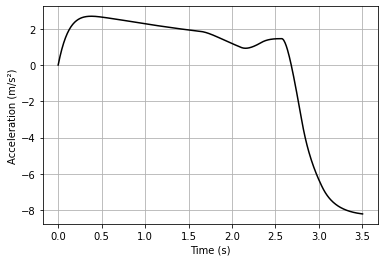

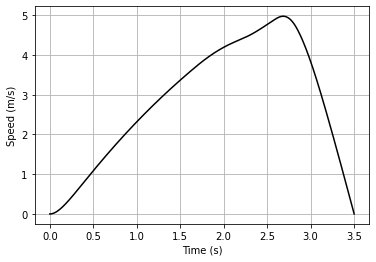

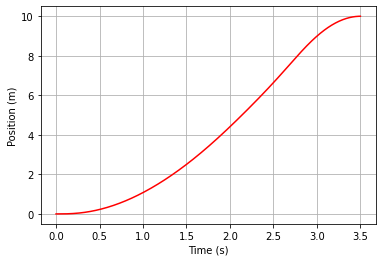

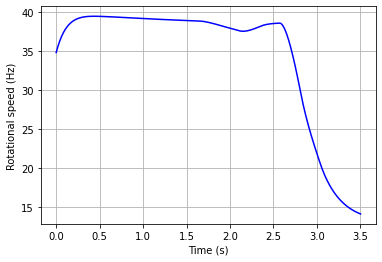

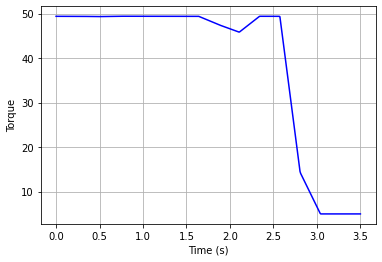

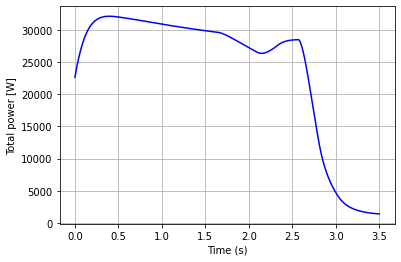

In [29]:
plot_trajectory(optim_problem.model.trajectory.trajectory.res)

In [30]:
OUTPUT_FILE = pth.join(WORK_FOLDER_PATH, 'problem_outputs.xml')

The `optimizer_viewer` offers a convenient summary of the optimization result:

In [31]:
api.optimization_viewer(CONFIGURATION_FILE)

You can use the `VariableViewer` tool to see the optimization results for all variables of the system by loading the .xml output file:

In [7]:
api.variable_viewer(OUTPUT_FILE)

In [22]:
import openmdao.api as om
from models.multirotor import Multirotor
prob = om.Problem()
prob.model = Multirotor()

prob.setup(check=True)

RuntimeError: <model> <class Multirotor>: Output name 'data:system:MTOW' refers to multiple outputs: ['mtow.data:system:MTOW', 'system_constraints.mtow.data:system:MTOW'].